## shNfkb1-lane1

2/2/24 - Data generated from shNfkb1 single hairpin experiments; included shRNA hairpin library, nonbarcoded; data submitted by Jason/Hannah/CHP on 5/23/2023

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib 
from matplotlib import pyplot as plt

import anndata
from pathlib import Path

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [4]:
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
results_file = 'write/JC2434-shNfkb1.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_h5('JC2434_filtered_feature_bc_matrix.h5', gex_only=False)

reading JC2434_filtered_feature_bc_matrix.h5
 (0:00:01)


/home/chanj2/part2a/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [9]:
print(samples)

['AW1781_Renilla', 'AX1068_Renilla', 'AX1127_2117', 'AX1893_2117', 'AW1785_2118', 'AW1426_Renilla', 'AW1427_Renilla', 'AX1508_2117', 'AX1598_2117', 'AW1555_2118']


In [10]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [11]:
hashadata.var

gene_ids     feature_types genome                    pattern  \
AW1781_Renilla   AW1781  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1068_Renilla   AX1068  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1127_2117      AX1127  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1893_2117      AX1893  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1785_2118      AW1785  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1426_Renilla   AW1426  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1427_Renilla   AW1427  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1508_2117      AX1508  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1598_2117      AX1598  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1555_2118      AW1555  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   

               read         sequence  
AW1781_Renilla   R2  ACCCACCAGTAAGAC  
AX1068_Renilla   R2  GGTCGAGAGCATTCA  
AX1127_2117      R2  CTTGCCGCATGTCAT  
AX1893_2117      R2  AAAGCATTCTTCACG  
AW1785_2118      R2  CTTTGTCTTTGTGAG  
AW1426_Renilla   R2  TATGCTGCCACGGTA  
AW1427_Renilla   R2  GAGTCTGCCAGTATC  
AX1508_2117      R2  TATAGAACGCCAGGC  
AX1598_2117      R2  TGCCTATGAAACAAG  
AW1555_2118      R2  CCGATTGTAACAGAC

## Preprocessing

/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


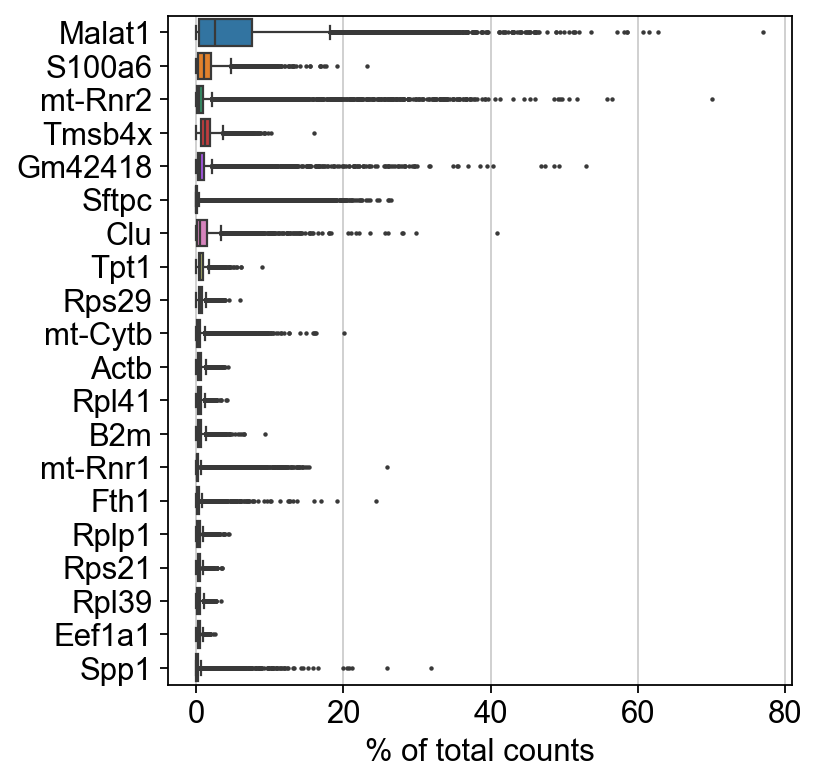

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [13]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 926 cells that have less than 1500 counts
filtered out 3 cells that have less than 300 genes expressed
filtered out 27091 genes that are detected in less than 3 cells


In [14]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

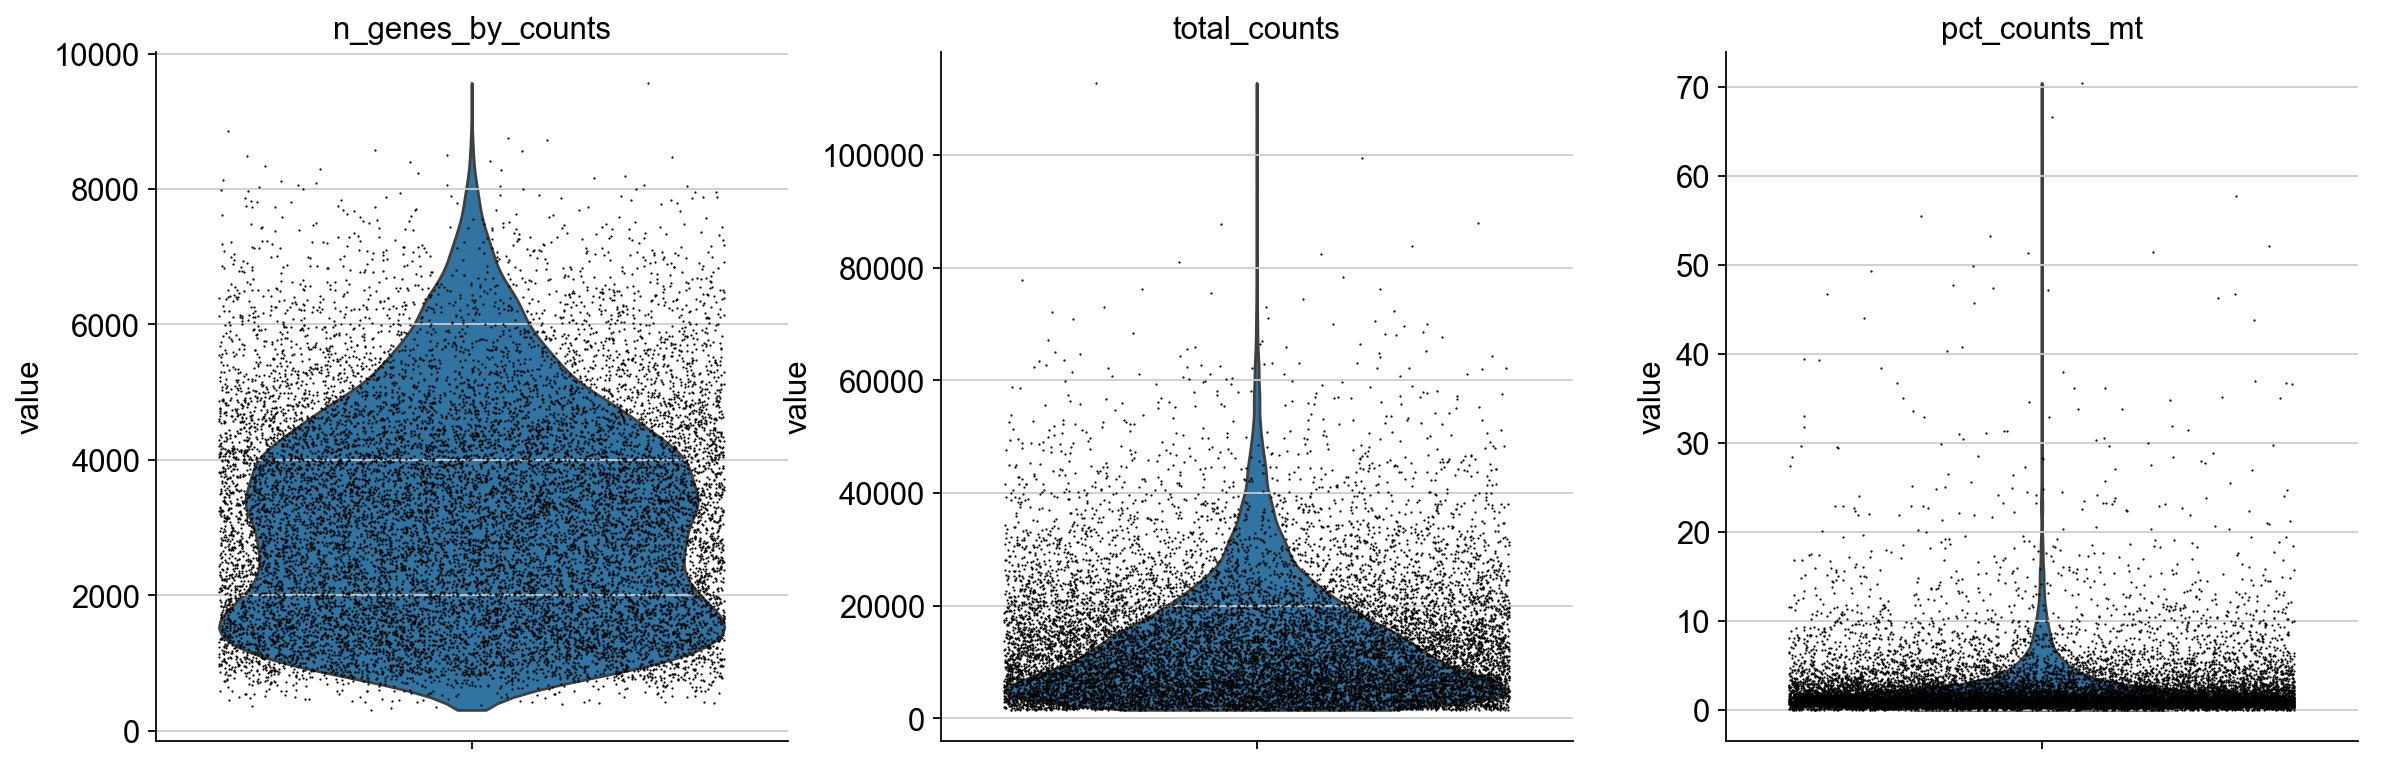

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([1.000e+00, 9.000e+00, 4.200e+01, 1.630e+02, 6.480e+02, 2.770e+03,
        5.117e+03, 4.324e+03, 1.962e+03, 1.820e+02]),
 array([0.68812436, 0.71386596, 0.73960756, 0.76534915, 0.79109075,
        0.81683234, 0.84257394, 0.86831553, 0.89405713, 0.91979873,
        0.94554032]),
 <BarContainer object of 10 artists>)

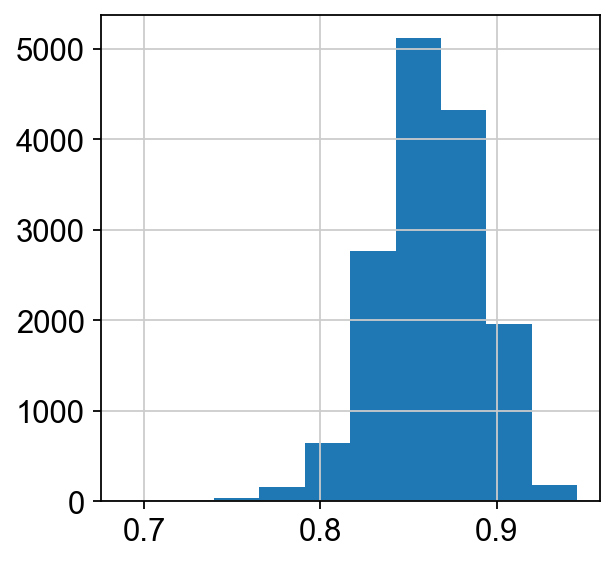

In [16]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

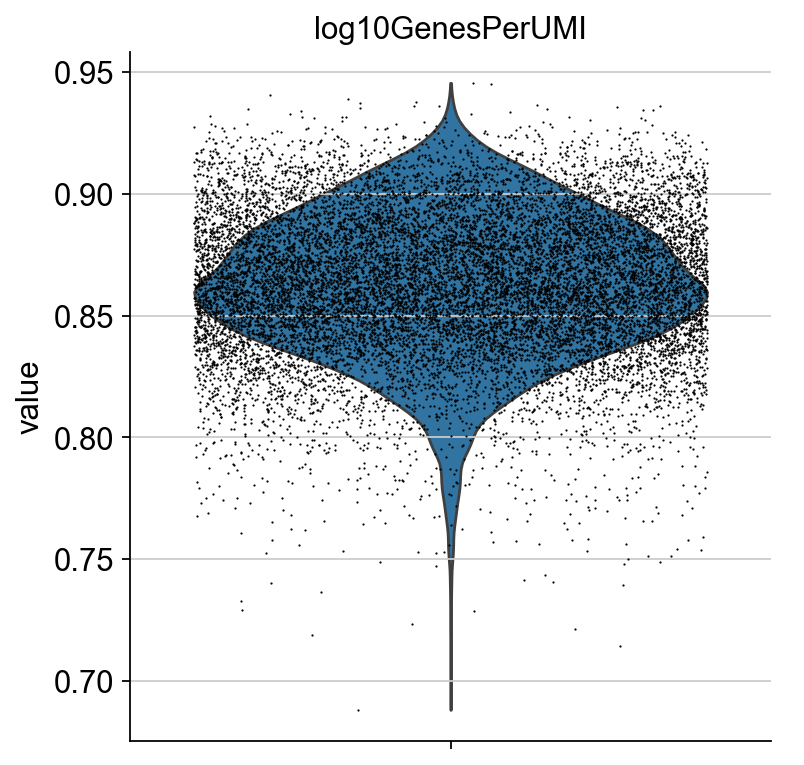

In [17]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)
#99% seems like a good Human pct count cutoff

Keep singlets, remove cells that have too many mouse reads, or mitochondrial genes expressed or too many total counts:

In [18]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [19]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [20]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [21]:
hashadata.var_names

Index(['AW1781_Renilla', 'AX1068_Renilla', 'AX1127_2117', 'AX1893_2117',
       'AW1785_2118', 'AW1426_Renilla', 'AW1427_Renilla', 'AX1508_2117',
       'AX1598_2117', 'AW1555_2118'],
      dtype='object')

In [22]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [23]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
hashDisc

AW1781_Renilla  AX1068_Renilla   AX1127_2117   AX1893_2117  \
count    14740.000000    14740.000000  14740.000000  14740.000000   
mean       335.565063      545.493835    307.665131    666.661926   
std       1306.990723     3756.722412   1023.843567   1790.059937   
min          0.000000        0.000000      0.000000      0.000000   
10%          6.000000       17.000000      5.000000     15.000000   
20%          8.000000       21.000000      7.000000     19.000000   
30%         10.000000       25.000000      8.000000     23.000000   
40%         12.000000       30.000000     10.000000     27.000000   
50%         13.000000       36.000000     12.000000     33.000000   
60%         16.000000       47.000000     15.000000     45.000000   
70%         19.000000       78.000000     21.000000     89.000000   
80%         25.000000      534.200000     34.000000    442.000000   
90%         63.000000     1739.100000    983.100000   2134.100000   
99%       6435.470000     5831.660000   4813.220000   8835.050000   
max      32602.000000   348900.000000  41731.000000  23251.000000   

        AW1785_2118  AW1426_Renilla  AW1427_Renilla   AX1508_2117  \
count  14740.000000    14740.000000    14740.000000  14740.000000   
mean       8.443555      315.583160      200.842056    190.227676   
std      116.569618     1035.859741      743.655823    739.551575   
min        0.000000        0.000000        0.000000      0.000000   
10%        0.000000        8.000000        2.000000     10.000000   
20%        0.000000       10.000000        3.000000     12.000000   
30%        0.000000       12.000000        4.000000     14.000000   
40%        0.000000       14.000000        5.000000     16.000000   
50%        0.000000       16.000000        6.000000     19.000000   
60%        0.000000       19.000000        7.000000     21.000000   
70%        1.000000       24.000000        9.000000     26.000000   
80%        1.000000       37.000000       12.000000     34.000000   
90%        1.000000      920.000000      171.000000    259.000000   
99%        8.000000     5133.150000     3841.610000   3528.540000   
max     3379.000000    18264.000000    12475.000000  21749.000000   

        AX1598_2117   AW1555_2118  
count  14740.000000  14740.000000  
mean     325.905823     18.199118  
std     1368.099487    285.454559  
min        0.000000      0.000000  
10%        6.000000      0.000000  
20%        8.000000      0.000000  
30%       10.000000      0.000000  
40%       11.000000      0.000000  
50%       13.000000      0.000000  
60%       16.000000      0.000000  
70%       19.000000      1.000000  
80%       27.000000      1.000000  
90%       75.000000      2.000000  
99%     7123.930000     17.000000  
max    35421.000000  12477.000000

In [24]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
hashIDs

AW1781_Renilla
63.0
AX1068_Renilla
1739.1000000000004
AX1127_2117
983.1000000000004
AX1893_2117
2134.1000000000004
AW1785_2118
1.0
AW1426_Renilla
920.0
AW1427_Renilla
171.0
AX1508_2117
259.0
AX1598_2117
75.0
AW1555_2118
2.0


/tmp/ipykernel_3374137/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_3374137/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_3374137/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float32, please exp

AW1781_Renilla  AX1068_Renilla  AX1127_2117  AX1893_2117  \
AAACCCAAGGGCATGT-1           False            True        False        False   
AAACCCAAGTTCTCTT-1           False           False        False        False   
AAACCCACAAGGTCGA-1           False           False        False        False   
AAACCCACACAAGCTT-1           False           False        False        False   
AAACCCACACAGCGCT-1            True           False         True        False   
...                            ...             ...          ...          ...   
TTTGTTGTCCGAAGGA-1           False           False        False        False   
TTTGTTGTCGTGCACG-1           False           False        False        False   
TTTGTTGTCTCCAAGA-1           False           False         True        False   
TTTGTTGTCTGAACGT-1           False           False        False        False   
TTTGTTGTCTTTGGAG-1           False           False        False        False   

                    AW1785_2118  AW1426_Renilla  AW1427_Renilla  AX1508_2117  \
AAACCCAAGGGCATGT-1         True            True           False         True   
AAACCCAAGTTCTCTT-1        False           False           False        False   
AAACCCACAAGGTCGA-1        False           False           False        False   
AAACCCACACAAGCTT-1        False           False           False        False   
AAACCCACACAGCGCT-1         True           False           False        False   
...                         ...             ...             ...          ...   
TTTGTTGTCCGAAGGA-1        False           False           False        False   
TTTGTTGTCGTGCACG-1        False           False           False        False   
TTTGTTGTCTCCAAGA-1        False           False           False        False   
TTTGTTGTCTGAACGT-1        False           False           False        False   
TTTGTTGTCTTTGGAG-1        False           False           False         True   

                    AX1598_2117  AW1555_2118  
AAACCCAAGGGCATGT-1         True        False  
AAACCCAAGTTCTCTT-1         True        False  
AAACCCACAAGGTCGA-1        False        False  
AAACCCACACAAGCTT-1        False        False  
AAACCCACACAGCGCT-1        False        False  
...                         ...          ...  
TTTGTTGTCCGAAGGA-1        False        False  
TTTGTTGTCGTGCACG-1        False        False  
TTTGTTGTCTCCAAGA-1        False        False  
TTTGTTGTCTGAACGT-1        False        False  
TTTGTTGTCTTTGGAG-1        False        False  

[14740 rows x 10 columns]

In [25]:
from matplotlib import pyplot as plt

In [26]:
hashCounts

AW1781_Renilla  AX1068_Renilla  AX1127_2117  AX1893_2117  \
AAACCCAAGGGCATGT-1            10.0          2717.0         20.0         50.0   
AAACCCAAGTTCTCTT-1             5.0            28.0         10.0         13.0   
AAACCCACAAGGTCGA-1            12.0            30.0         14.0        187.0   
AAACCCACACAAGCTT-1            12.0            34.0        680.0         29.0   
AAACCCACACAGCGCT-1         10927.0            77.0       2443.0         41.0   
...                            ...             ...          ...          ...   
TTTGTTGTCCGAAGGA-1            11.0            10.0        709.0          8.0   
TTTGTTGTCGTGCACG-1            45.0           169.0         22.0        625.0   
TTTGTTGTCTCCAAGA-1             9.0            21.0       2050.0        175.0   
TTTGTTGTCTGAACGT-1             6.0            26.0         31.0        182.0   
TTTGTTGTCTTTGGAG-1             5.0             8.0          1.0          8.0   

                    AW1785_2118  AW1426_Renilla  AW1427_Renilla  AX1508_2117  \
AAACCCAAGGGCATGT-1          2.0          1831.0            11.0        331.0   
AAACCCAAGTTCTCTT-1          0.0             4.0             3.0         11.0   
AAACCCACAAGGTCGA-1          0.0            13.0             4.0         23.0   
AAACCCACACAAGCTT-1          1.0            31.0             3.0         11.0   
AAACCCACACAGCGCT-1          9.0            28.0            13.0         28.0   
...                         ...             ...             ...          ...   
TTTGTTGTCCGAAGGA-1          0.0             7.0             2.0         11.0   
TTTGTTGTCGTGCACG-1          1.0            33.0             9.0         49.0   
TTTGTTGTCTCCAAGA-1          0.0            11.0             2.0          8.0   
TTTGTTGTCTGAACGT-1          0.0             9.0             3.0         14.0   
TTTGTTGTCTTTGGAG-1          0.0            18.0             1.0        307.0   

                    AX1598_2117  AW1555_2118  
AAACCCAAGGGCATGT-1         85.0          1.0  
AAACCCAAGTTCTCTT-1       1730.0          0.0  
AAACCCACAAGGTCGA-1          9.0          0.0  
AAACCCACACAAGCTT-1         10.0          0.0  
AAACCCACACAGCGCT-1         25.0          0.0  
...                         ...          ...  
TTTGTTGTCCGAAGGA-1          9.0          0.0  
TTTGTTGTCGTGCACG-1         33.0          0.0  
TTTGTTGTCTCCAAGA-1         12.0          0.0  
TTTGTTGTCTGAACGT-1         16.0          2.0  
TTTGTTGTCTTTGGAG-1          6.0          0.0  

[14740 rows x 10 columns]

In [27]:
plt.rcParams['figure.figsize'] = (4,4)

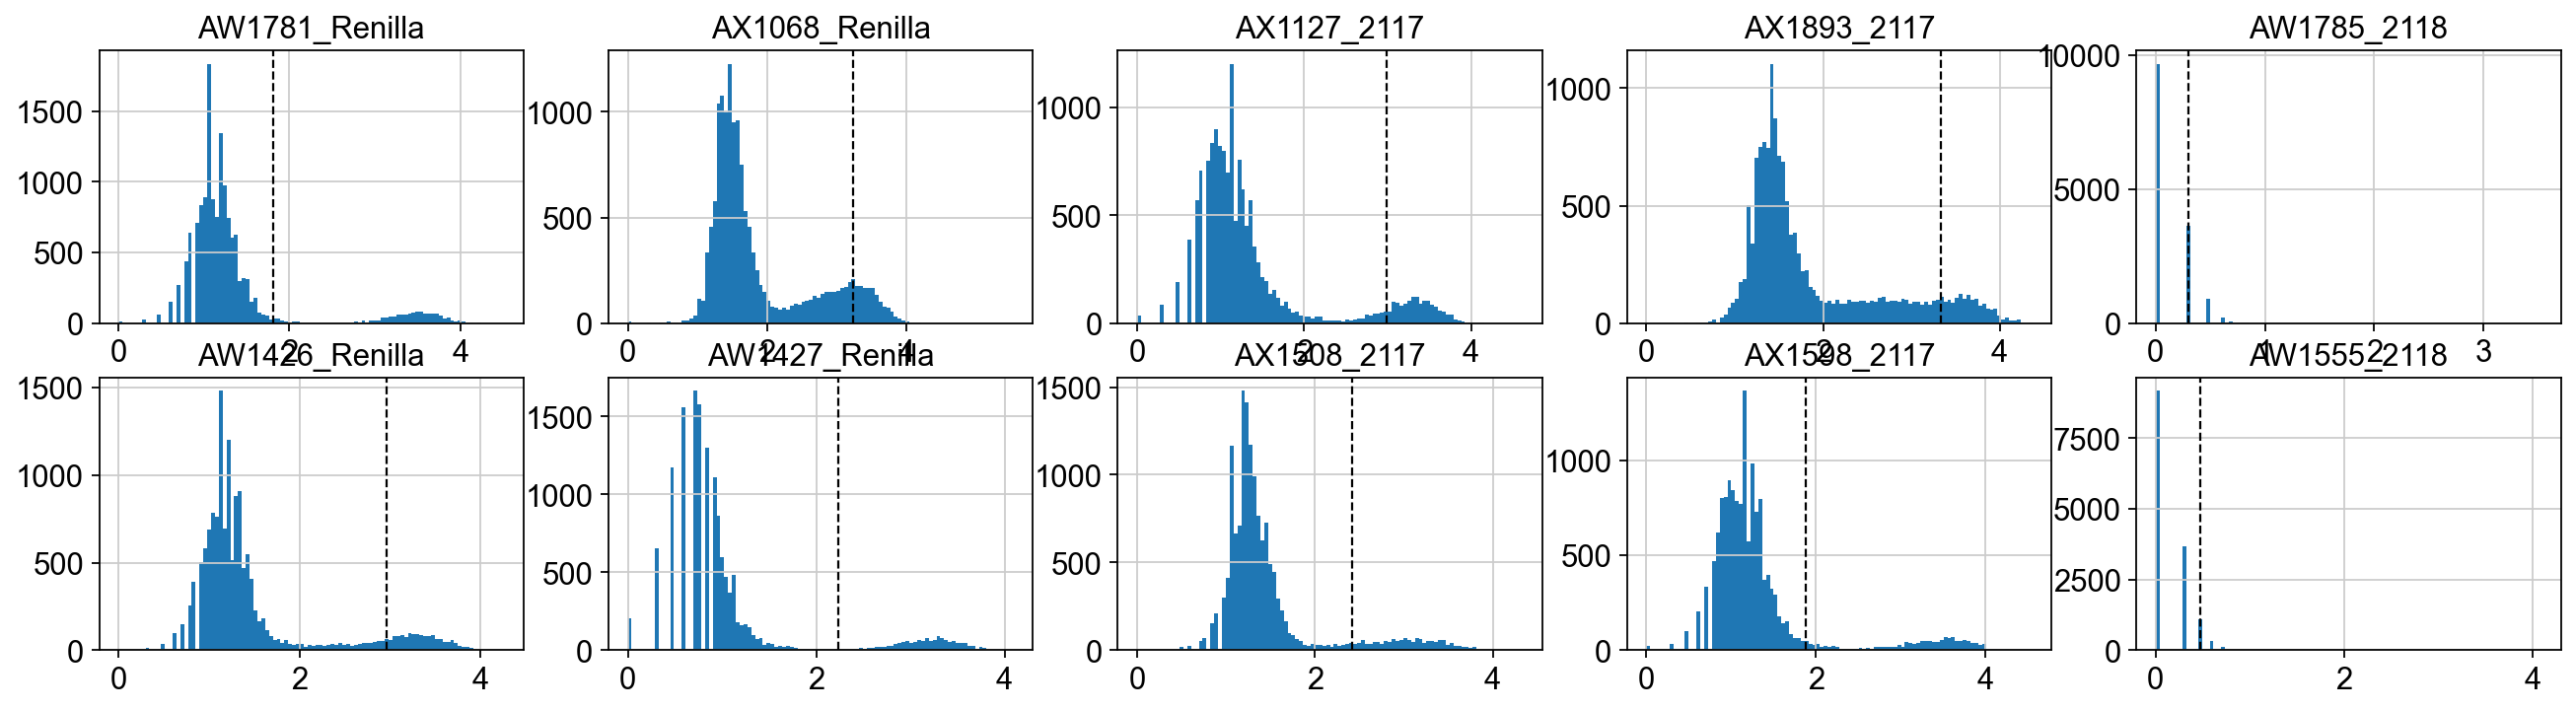

In [28]:
fig, axs = plt.subplots(2,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

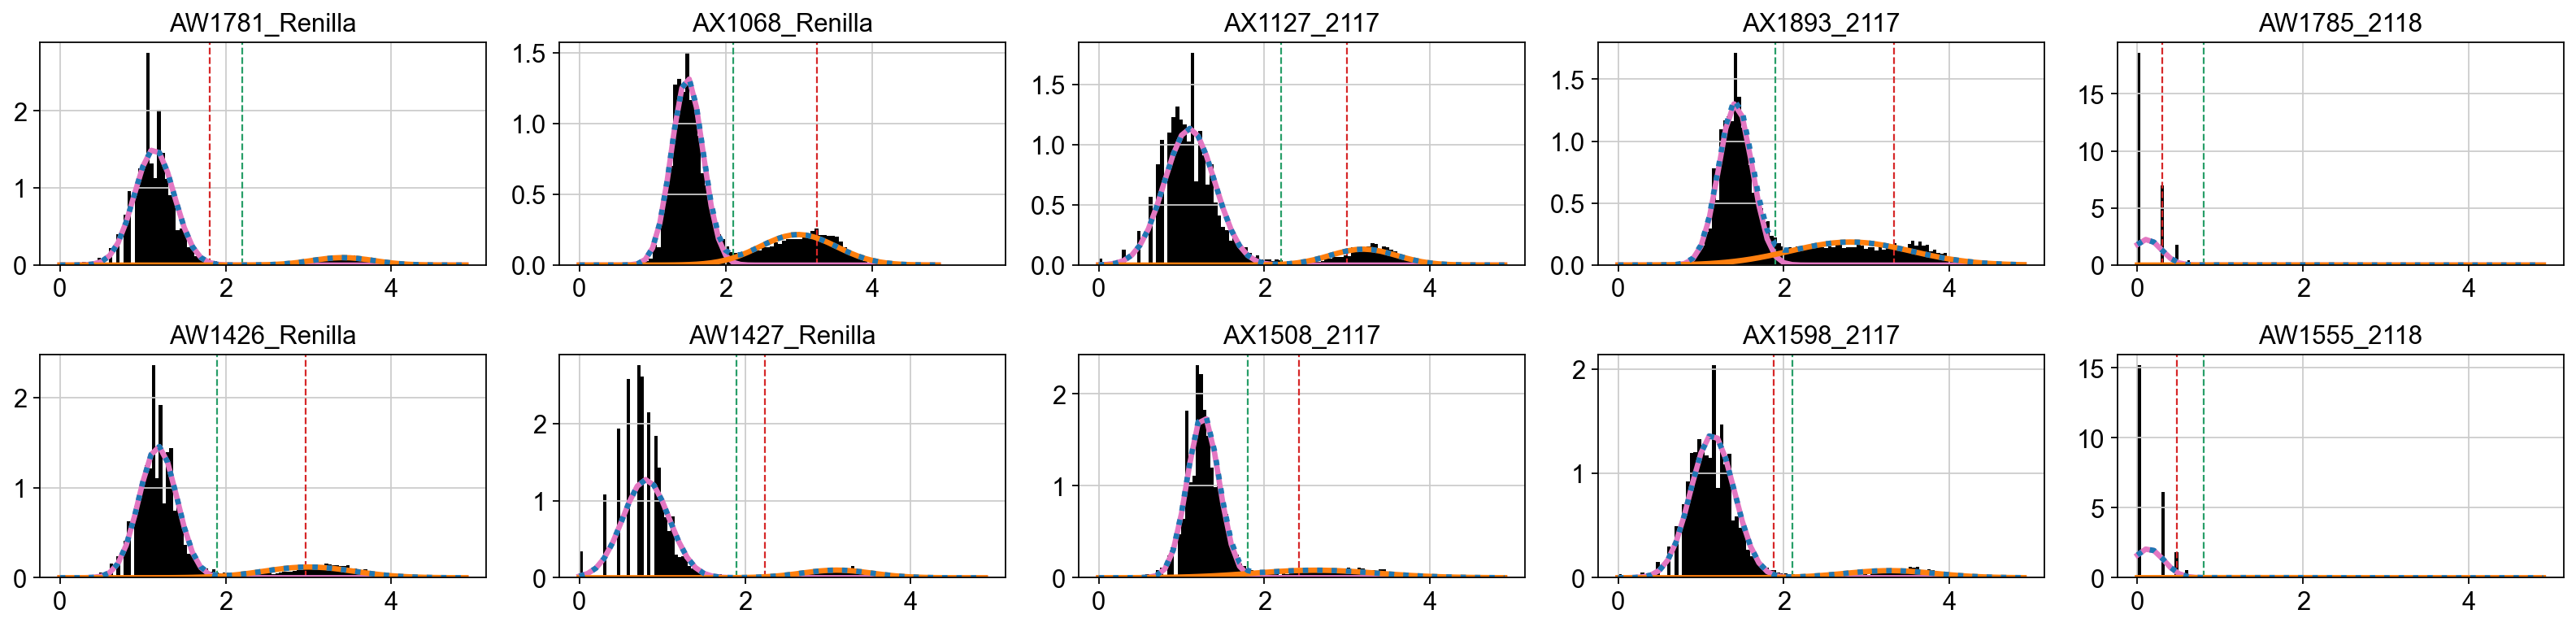

In [29]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    if mean[0][0] < mean[1][0]:
        left_idx, right_idx = 0, 1
    else:
        left_idx, right_idx = 1, 0

    
    x_axis = np.arange(0, 5, 0.1)
    
    y_left = norm.pdf(x_axis, float(mean[left_idx][0]), np.sqrt(float(covs[left_idx][0][0]))) * weights[left_idx]
    y_right = norm.pdf(x_axis, float(mean[right_idx][0]), np.sqrt(float(covs[right_idx][0][0]))) * weights[right_idx]

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]  

    diff = y_right - y_left
    crossings = np.where(np.diff(np.sign(diff)) > 0)[0]  # where right overtakes left
    
    if len(crossings) > 0:
        # Take the first crossing where right becomes dominant
        idx = crossings[0]
        hashBoundry = x_axis[idx + 1]  # slightly to the right
    else:
        # If no intersection found, fall back to right mean or a fixed value
        hashBoundry = float(mean[right_idx][0])

    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_left, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_right, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_left+y_right, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [30]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
#set manual minimum threshold to be 1
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    #manually set minimum threshold to 1 given poor HashData
    if (dfHashBoundry.loc[hashName].values[0] < 1):
        dfHashBoundry.loc[hashName].values[0] = 1
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

AW1781_Renilla
2.2
2.2
AX1068_Renilla
2.1
2.1
AX1127_2117
2.2
2.2
AX1893_2117
1.9000000000000001
1.9000000000000001
AW1785_2118
0.8
1.0
AW1426_Renilla
1.9000000000000001
1.9000000000000001
AW1427_Renilla
1.9000000000000001
1.9000000000000001
AX1508_2117
1.8
1.8
AX1598_2117
2.1
2.1
AW1555_2118
0.8
1.0


/tmp/ipykernel_3374137/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_3374137/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_3374137/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' ha

In [31]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    #print(i)
    #print(hashBool)
    #print(hashBool.values)
    #print(sum(hashBool))
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [32]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/tmp/ipykernel_3374137/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/tmp/ipykernel_3374137/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
doublet           3692
AX1893_2117       2620
AX1068_Renilla    2285
AW1426_Renilla    1283
AX1127_2117       1076
AX1508_2117       1056
AW1427_Renilla     890
AX1598_2117        691
AW1781_Renilla     687
negative           351
AW1785_2118         59
AW1555_2118         50
Name: count, dtype: int64

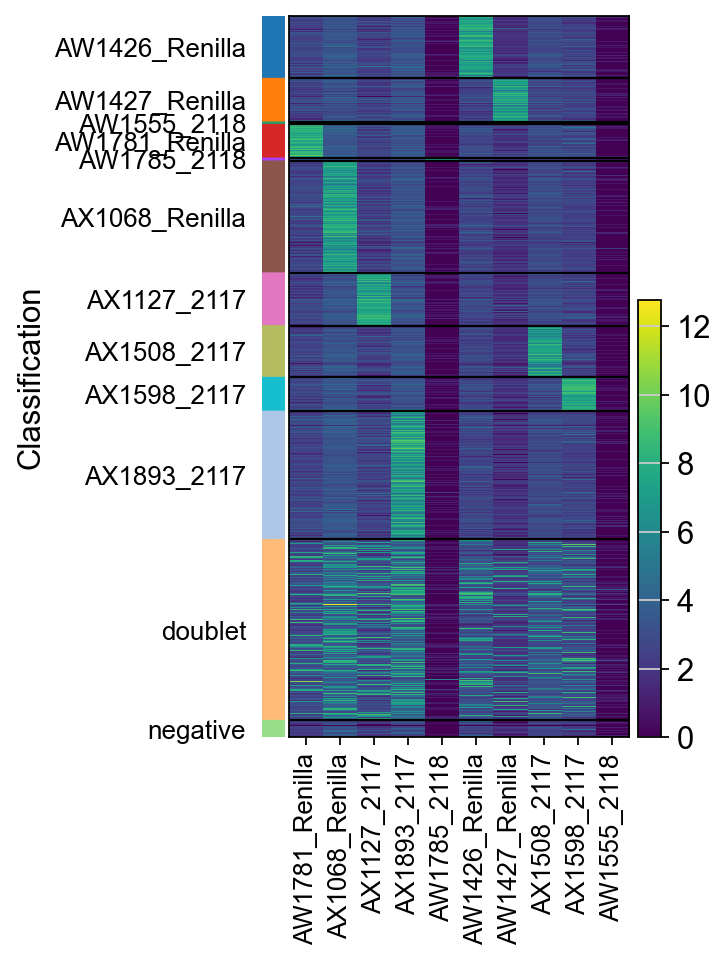

In [33]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set specialized gene counts

(array([1.4617e+04, 1.0000e+02, 1.7000e+01, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.        ,  11.39999962,  22.79999924,  34.19999695,
         45.59999847,  57.        ,  68.3999939 ,  79.79999542,
         91.19999695, 102.59999847, 114.        ]),
 <BarContainer object of 10 artists>)

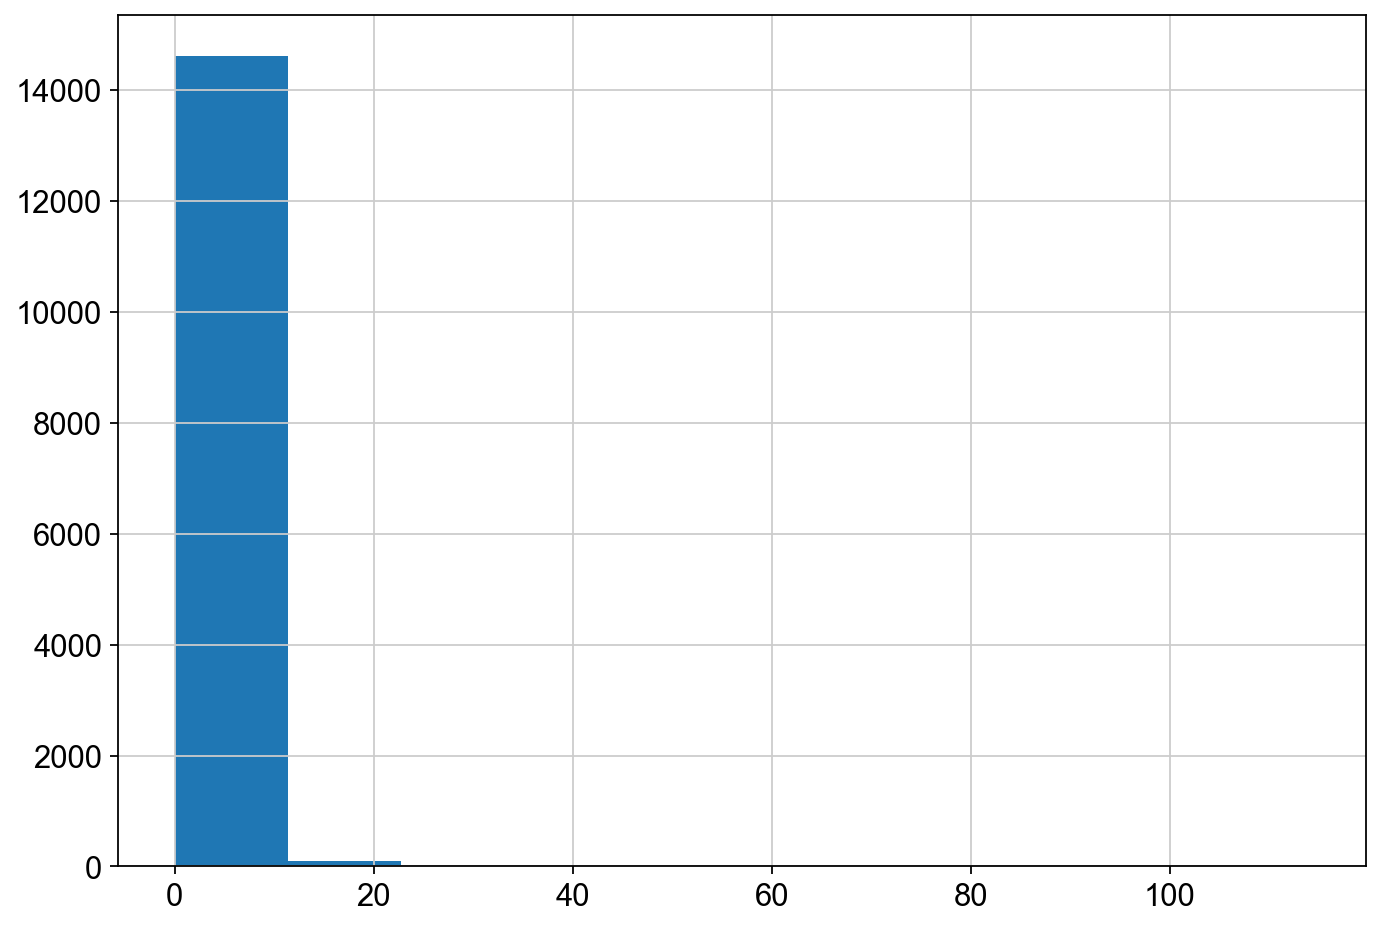

In [34]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['shRenilla'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['shRen'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [35]:
adata.obs['shRen'] = adata.X[:,adata.var.index.isin(['shRenilla'])].toarray()

(array([1.4696e+04, 1.4000e+01, 6.0000e+00, 8.0000e+00, 7.0000e+00,
        4.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.        ,  2.70000005,  5.4000001 ,  8.10000038, 10.80000019,
        13.5       , 16.20000076, 18.89999962, 21.60000038, 24.30000114,
        27.        ]),
 <BarContainer object of 10 artists>)

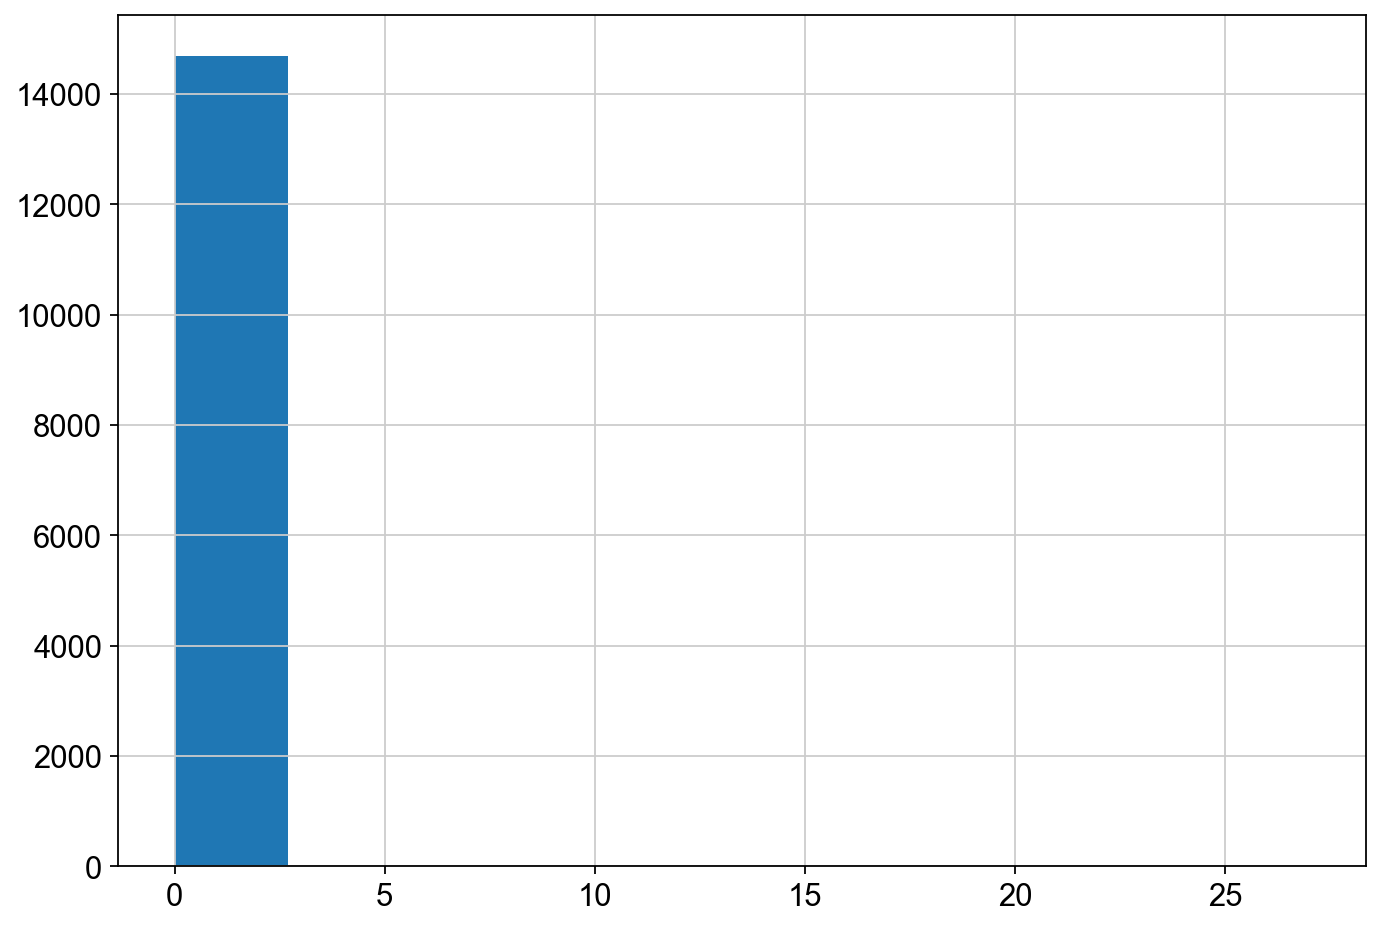

In [36]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['2118-Nfkb1.3737'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [37]:
adata.obs['2118-Nfkb1'] = adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray()

(array([1.3932e+04, 4.2900e+02, 2.1100e+02, 8.6000e+01, 5.3000e+01,
        2.0000e+01, 5.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.        ,  5.9000001 , 11.80000019, 17.70000076, 23.60000038,
        29.5       , 35.40000153, 41.29999924, 47.20000076, 53.10000229,
        59.        ]),
 <BarContainer object of 10 artists>)

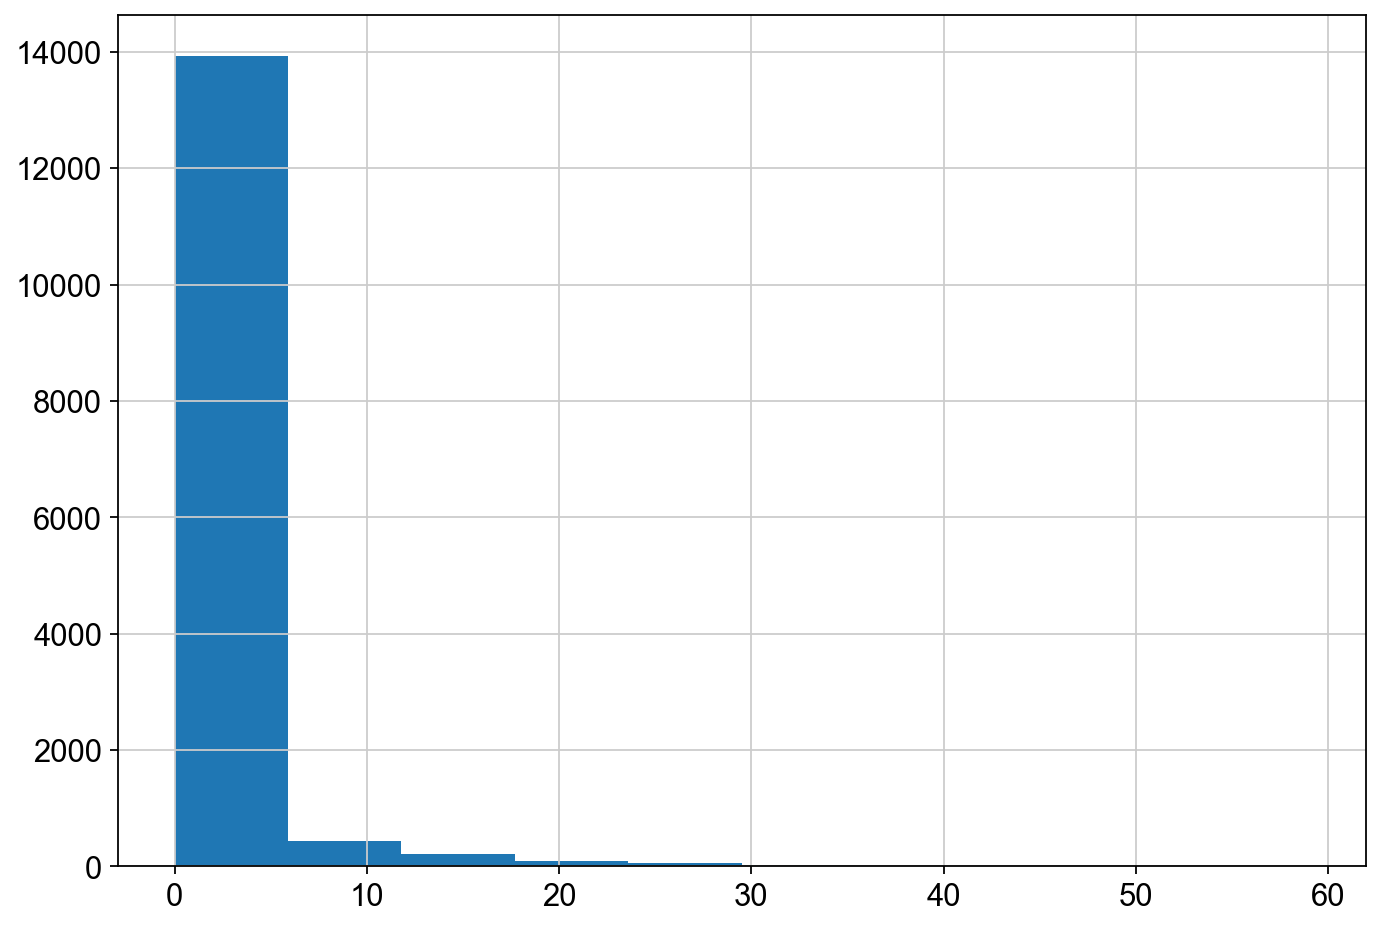

In [38]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['2117-Nfkb1.2331'])].toarray())

In [39]:
adata.obs['2117-Nfkb1'] = adata.X[:,adata.var.index.isin(['2117-Nfkb1.2331'])].toarray()

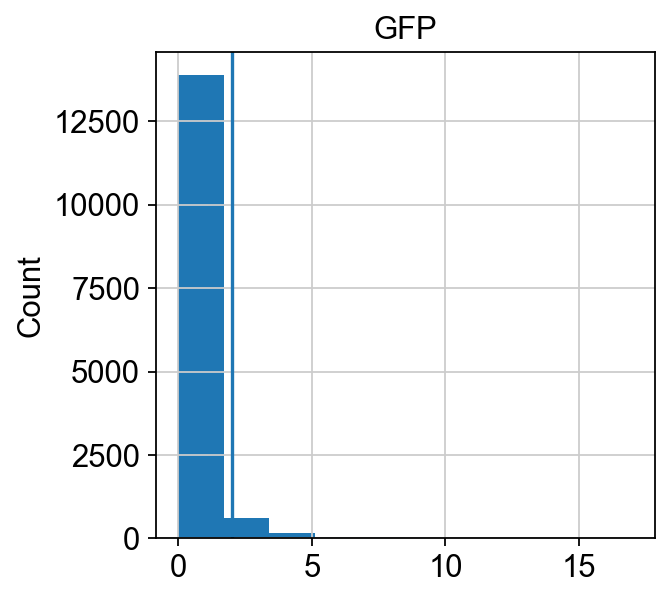

In [40]:
import matplotlib.pyplot as plt
adata.var.index.isin(['GFP'])
_ = plt.hist(adata[adata.obs.index,'GFP'].X.toarray())
plt.ylabel("Count")
plt.title("GFP")
plt.axvline(x=2)
plt.show()

In [41]:
adata.obs['GFP_count'] = adata.X[:,adata.var.index.isin(['GFP'])].toarray()

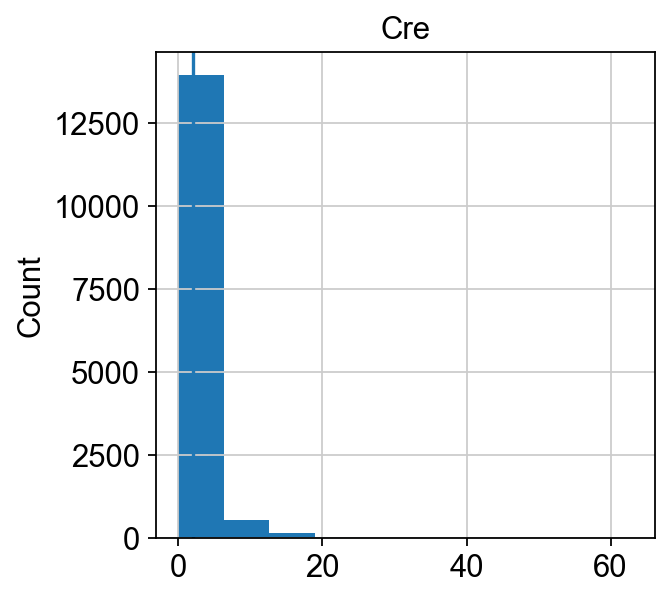

In [42]:
import matplotlib.pyplot as plt
adata.var.index.isin(['GFP'])
_ = plt.hist(adata[adata.obs.index,'Cre'].X.toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [43]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

## Filter doublets and negative cells

In [44]:
adata.obs.Classification.value_counts()

Classification
doublet           3692
AX1893_2117       2620
AX1068_Renilla    2285
AW1426_Renilla    1283
AX1127_2117       1076
AX1508_2117       1056
AW1427_Renilla     890
AX1598_2117        691
AW1781_Renilla     687
negative           351
AW1785_2118         59
AW1555_2118         50
Name: count, dtype: int64

In [45]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [46]:
adata.obs.Classification.value_counts()

Classification
AX1893_2117       2620
AX1068_Renilla    2285
AW1426_Renilla    1283
AX1127_2117       1076
AX1508_2117       1056
AW1427_Renilla     890
AX1598_2117        691
AW1781_Renilla     687
AW1785_2118         59
AW1555_2118         50
Name: count, dtype: int64

## Set Groups

In [47]:
#Set shRNA groups
adata.obs['shRNA'] = None
adata.obs['shRNA'][adata[adata.obs['shRen'] >= 2,:].obs.index] = 'shRenilla'
adata.obs['shRNA'][adata[adata.obs['2117-Nfkb1'] >= 2,:].obs.index] = '2117'
adata.obs['shRNA'][adata[adata.obs['2118-Nfkb1'] >= 2,:].obs.index] = '2118'

/tmp/ipykernel_3374137/4115219045.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['shRNA'] = None
/tmp/ipykernel_3374137/4115219045.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [48]:
#Select control mice
adata = adata[adata.obs.Classification.isin(['AX1508_2117','AX1598_2117','AW1555_2118','AW1426_Renilla','AW1427_Renilla']),:]

In [49]:
#Set shRNA groups
adata.obs['Group'] = 'shRenilla'
adata.obs['Group'][adata.obs.Classification.isin(['AX1508_2117','AX1598_2117'])] = 'shNfkb1_2331'
adata.obs['Group'][adata.obs.Classification.isin(['AW1555_2118'])] = 'shNfkb1_3737'

/tmp/ipykernel_3374137/1131628313.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'shRenilla'
/tmp/ipykernel_3374137/1131628313.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [50]:
adata.obs[['Group','Classification']].value_counts(sort=False)

Group         Classification
shNfkb1_2331  AX1508_2117       1056
              AX1598_2117        691
shNfkb1_3737  AW1555_2118         50
shRenilla     AW1426_Renilla    1283
              AW1427_Renilla     890
Name: count, dtype: int64

## Double check shRNAs and filter accordingly

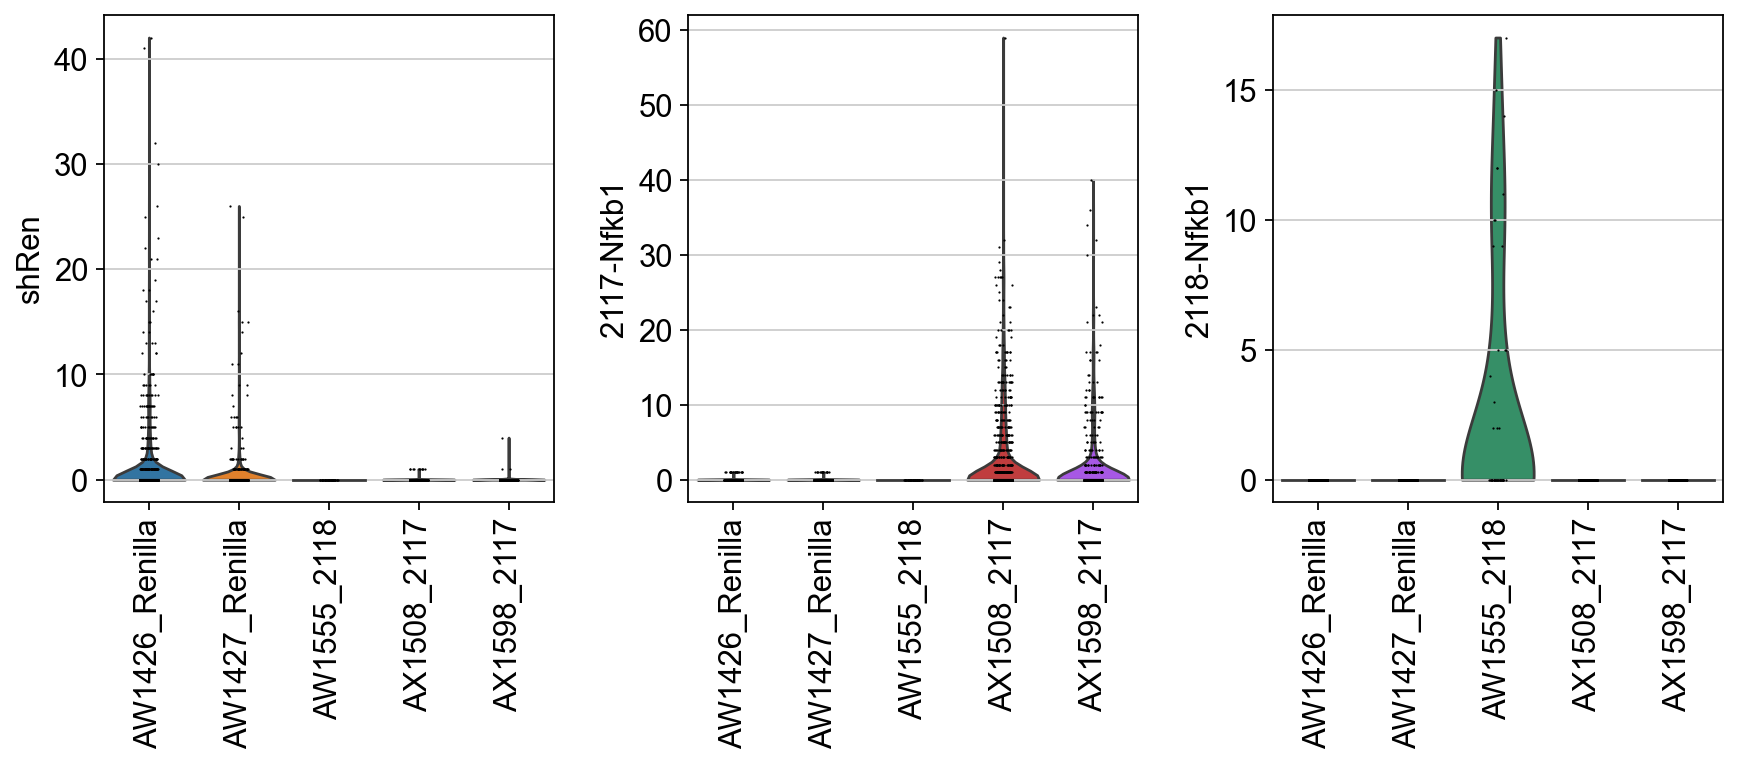

In [51]:
sc.pl.violin(adata,['shRen','2117-Nfkb1','2118-Nfkb1'], groupby='Classification', rotation=90)

In [52]:
adata.obs[['shRNA','Group']].value_counts()

shRNA      Group       
2117       shNfkb1_2331    376
shRenilla  shRenilla       197
2118       shNfkb1_3737     18
shRenilla  shNfkb1_2331      1
Name: count, dtype: int64

In [53]:
# remove 'doublet' by hairpin detection
adata = adata[~(adata.obs.shRNA.isin(['shRenilla']) & adata.obs.Group.isin(['shNfkb1_2331'])),:]

In [54]:
adata.obs[['shRNA','Group']].value_counts()

shRNA      Group       
2117       shNfkb1_2331    376
shRenilla  shRenilla       197
2118       shNfkb1_3737     18
Name: count, dtype: int64

/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


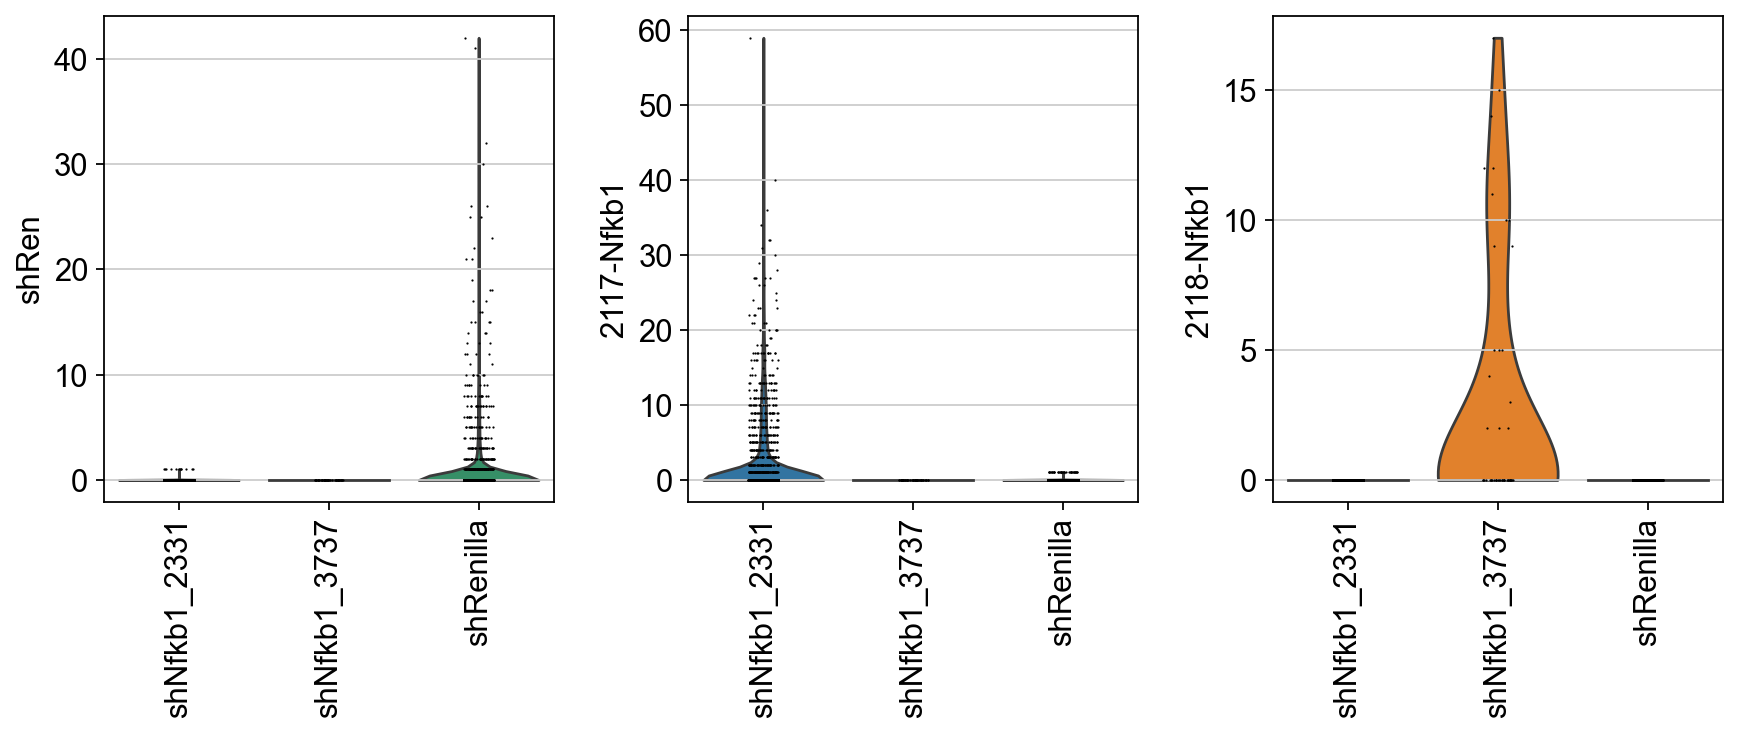

In [55]:
sc.pl.violin(adata,['shRen','2117-Nfkb1','2118-Nfkb1'], groupby='Group', rotation=90)

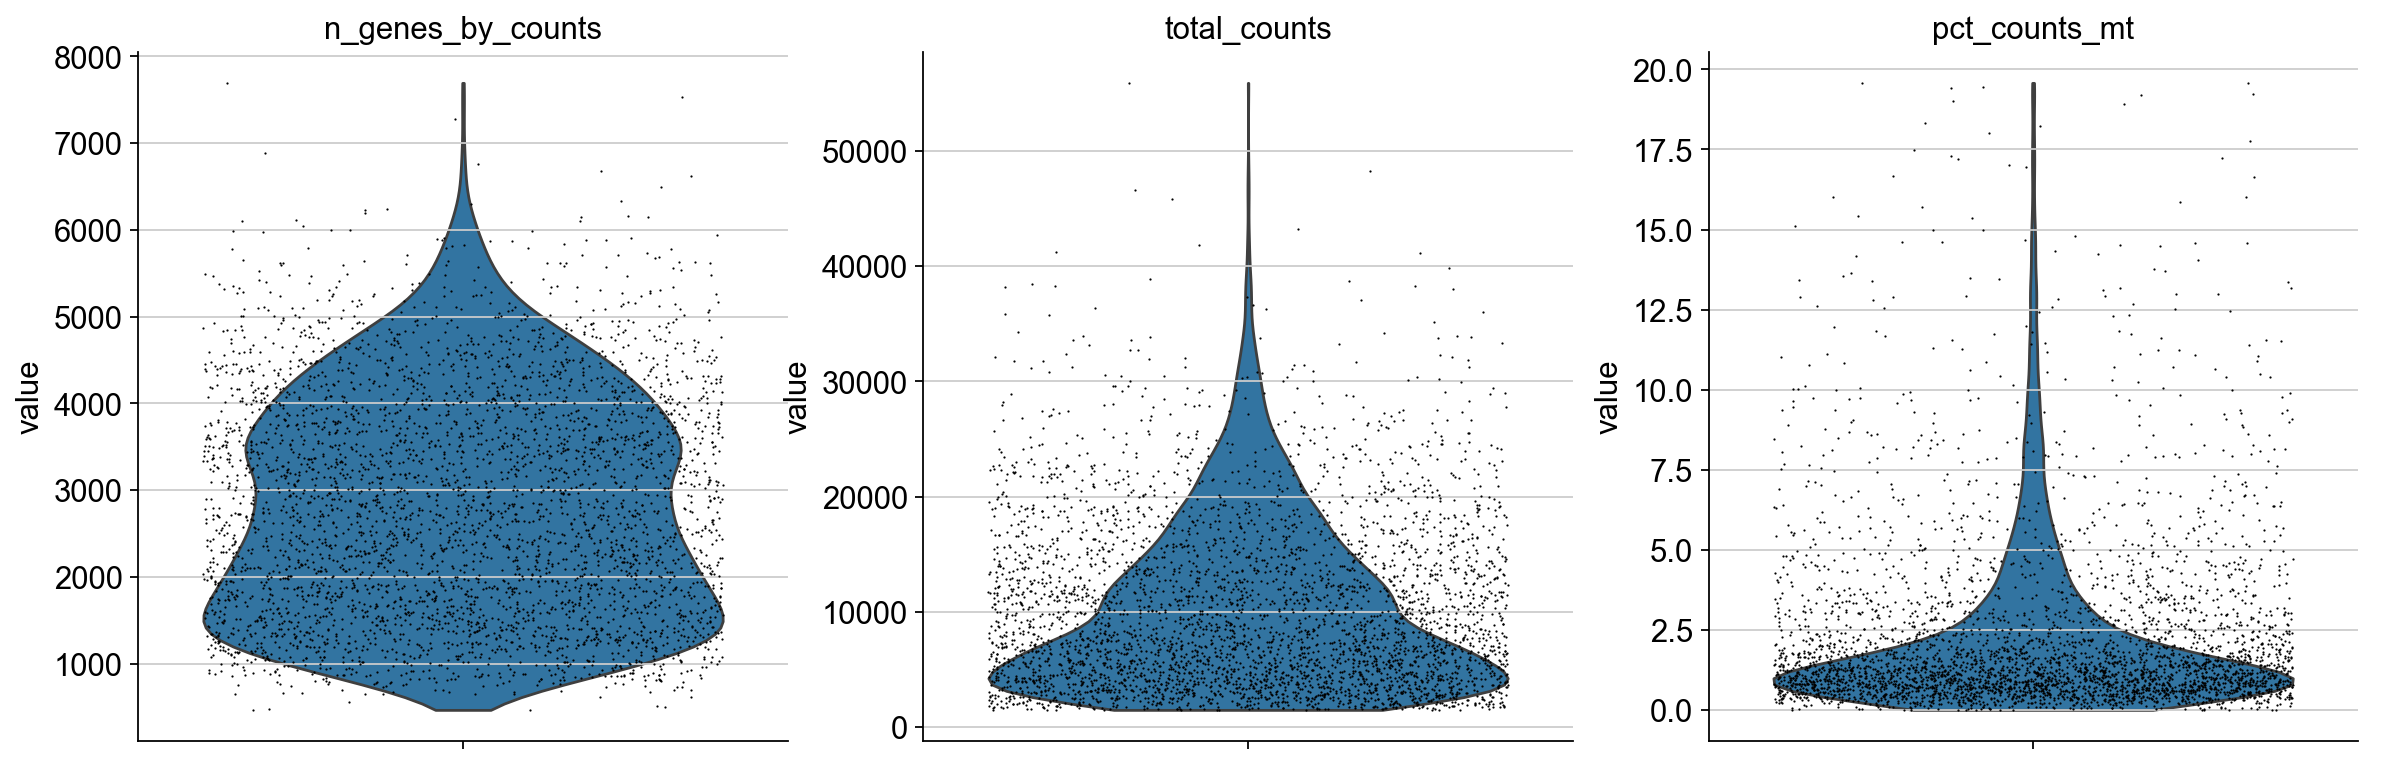

In [56]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

In [57]:
adata.layers['counts']=adata.X.copy()

In [58]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [59]:
sc.pp.log1p(adata)

In [60]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


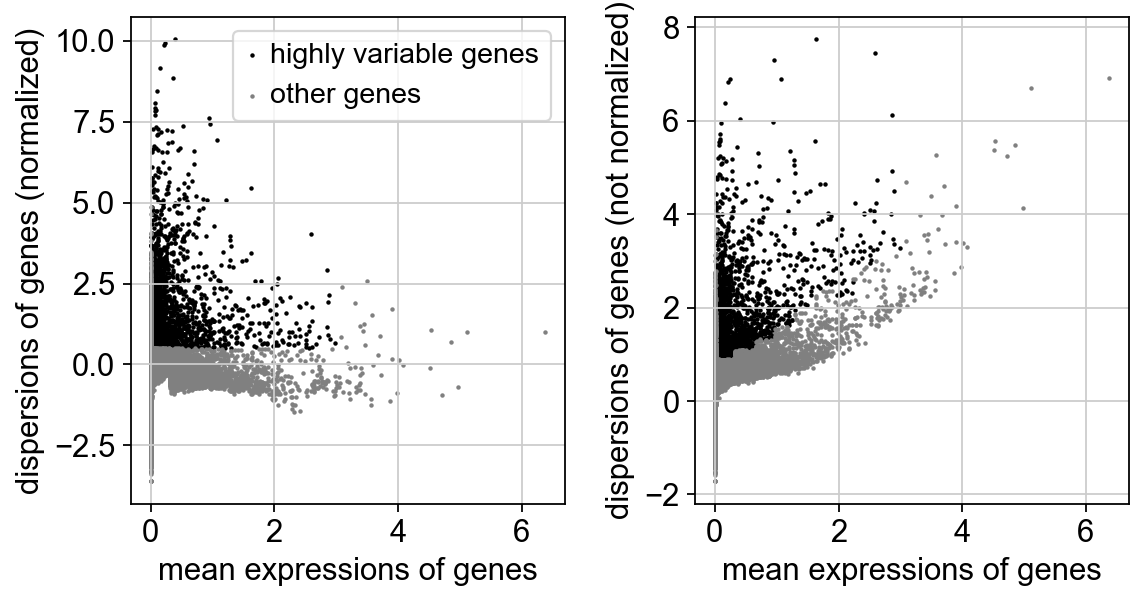

In [61]:
sc.pl.highly_variable_genes(adata)

In [62]:
library = ["1659-Fosl2.226","1660-Fosl2.752","1661-Fhl2.467","1662-Fhl2.179","1663-Myc.989","1664-Myc.1389","1665-Yap1.735","1666-Yap1.2847","1667-Atf4.1383","1668-Atf4.536","1669-Maff.85","1670-Maff.587","1671-Nfkb2.152","1672-Nfkb2.534","1673-Relb.286","1674-Relb.1795","1675-Onecut2.1799","1676-Onecut2.2361","1810-Slc4a11.541","1934-Slc4a11.1966","1811-Itga2.672","1812-Itga2.204","1998-Cldn4-1013","1999-Cldn4-951","2113-Lif.440","2114-Lif.1890","2115-Fosl1.1401","2116-Fosl1.699","2117-Nfkb1.2331","2118-Nfkb1.3737","2190-Jun_2481","2191-Jun_3136","2193-JunB_406","2194-JunD_78","2195-JunD_859","JCP618-Rela_1202","JCP621-Rela_1182","JCP623-Rel_1868","JCP625-Rel_342","JCP628-Ikbkg_2526","JCP629-Ikbkg_2984"]

In [63]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_3374137/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_3374137/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [64]:
adata.raw = adata

In [65]:
adata.write_h5ad('write/JC2434-allmice.h5ad', compression='gzip')

In [66]:
sc.pp.scale(adata, max_value=10)

/home/chanj2/part2a/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [67]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:06)


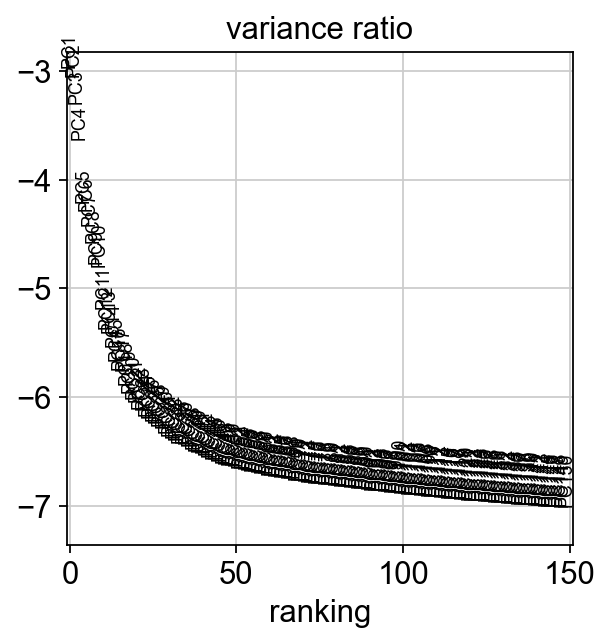

In [68]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

In [69]:
adata.write(results_file, compression='gzip')

In [70]:
adata

AnnData object with n_obs × n_vars = 3969 × 27782
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'shRen', '2118-Nfkb1', '2117-Nfkb1', 'GFP_count', 'Cre_count', 'shRNA', 'Group'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Classification_colors', 'Group_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## Computing the neighborhood graph

In [71]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/chanj2/part2a/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [72]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


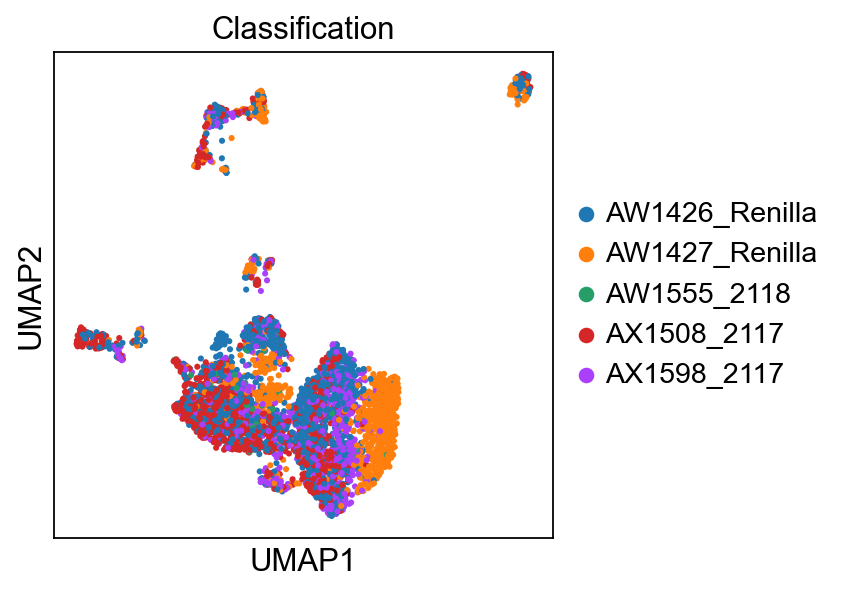

In [73]:
sc.pl.umap(adata, color=['Classification'])

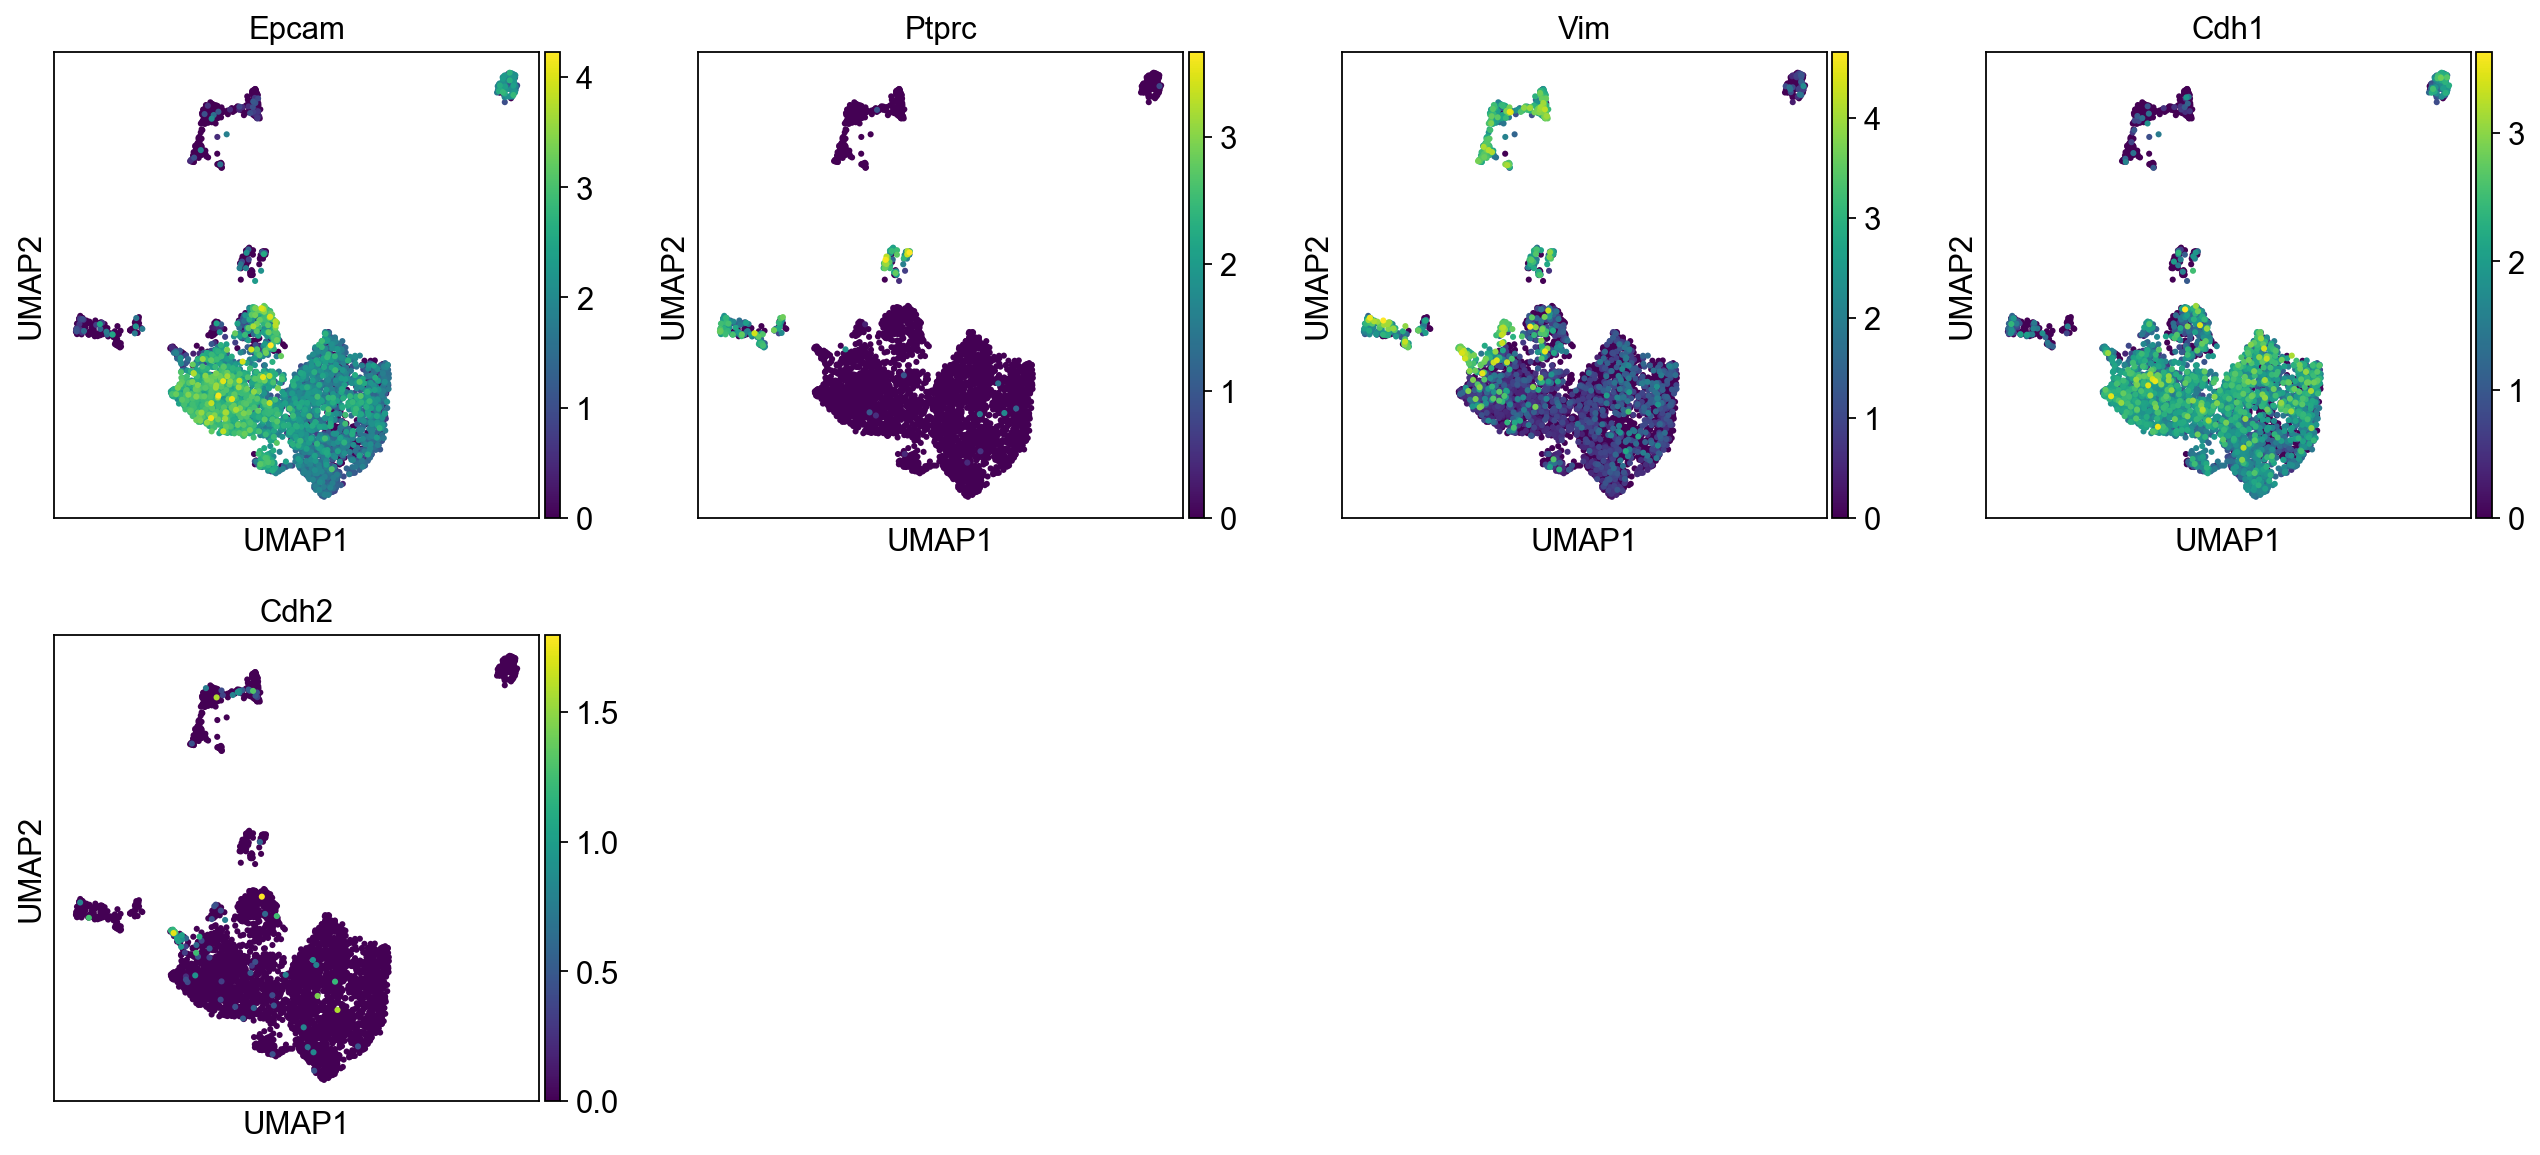

In [74]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1','Cdh2'])

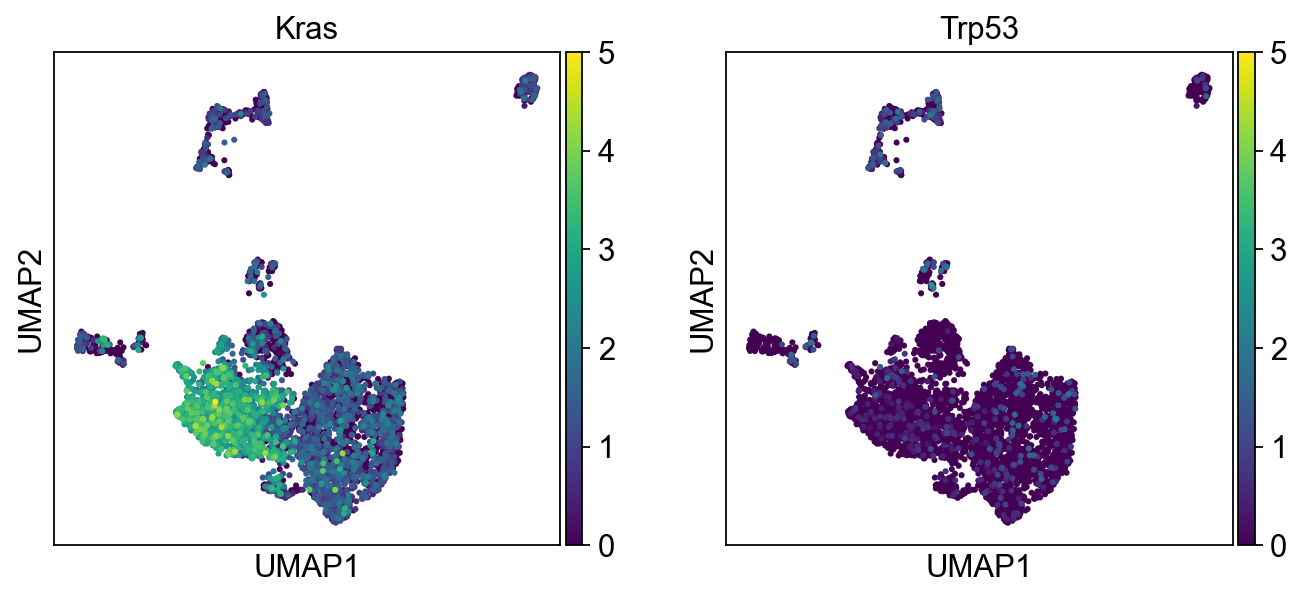

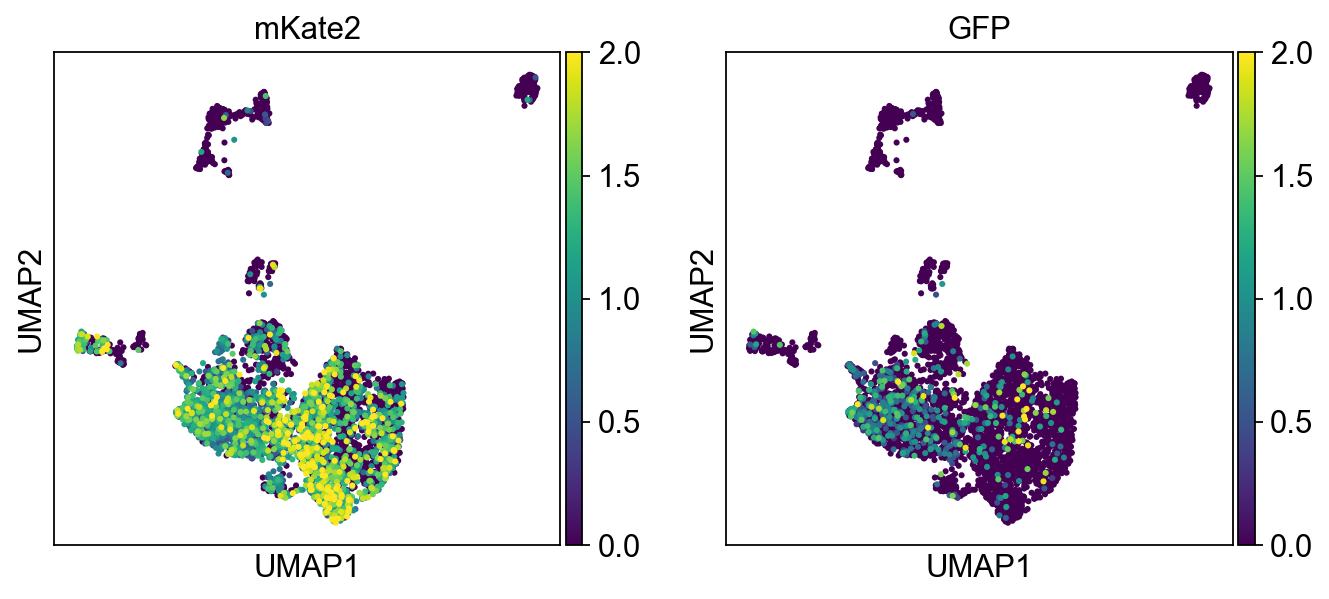

In [75]:
sc.pl.umap(adata, color=['Kras','Trp53'], vmax=5)
sc.pl.umap(adata, color=['mKate2','GFP'], vmax=2)

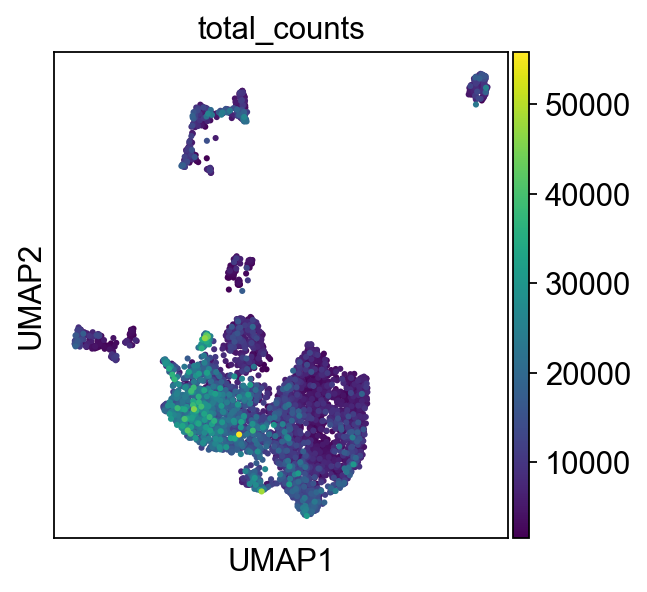

In [76]:
sc.pl.umap(adata, color=['total_counts'])

In [77]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [78]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
        #sc.tl.score_genes(ad, clusters['Highly_mixed'],score_name="Highly_mixed")
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [79]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1583 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1393 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1289 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1496 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1491 total control genes are used. (0:00:00)
computing score 'Cluster 6'
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2090 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.obs).
    1296 total control genes are u

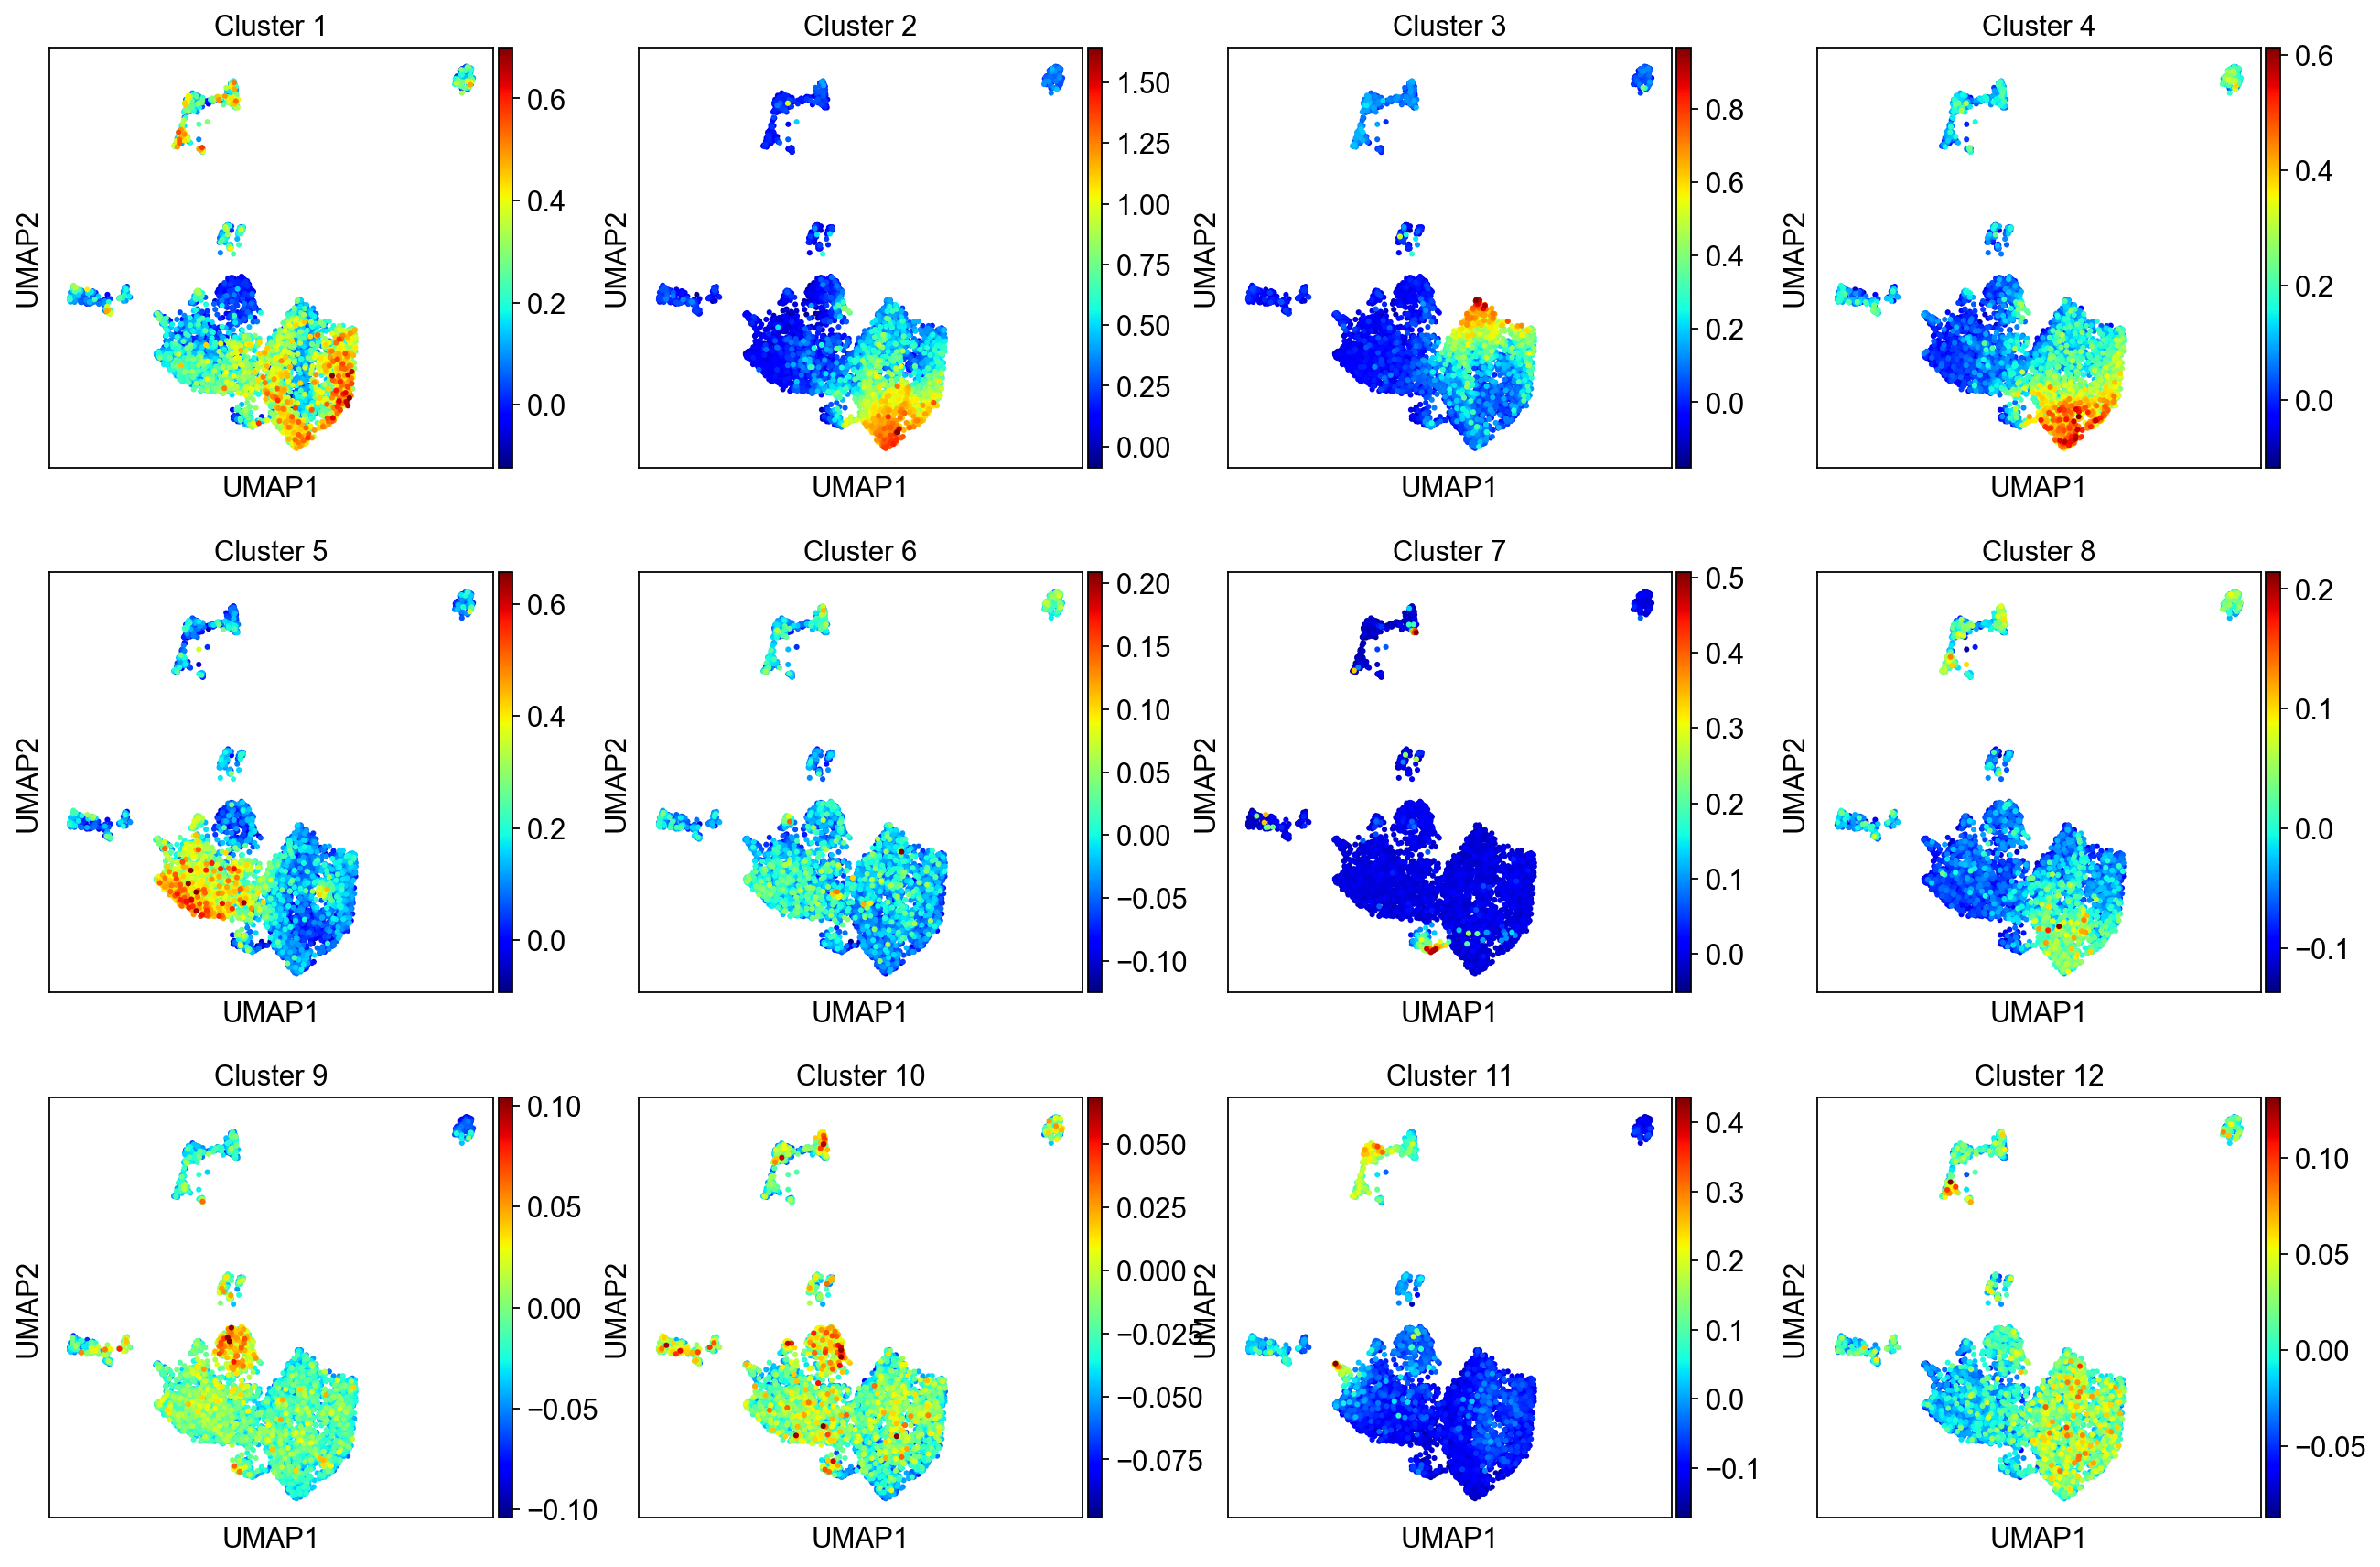

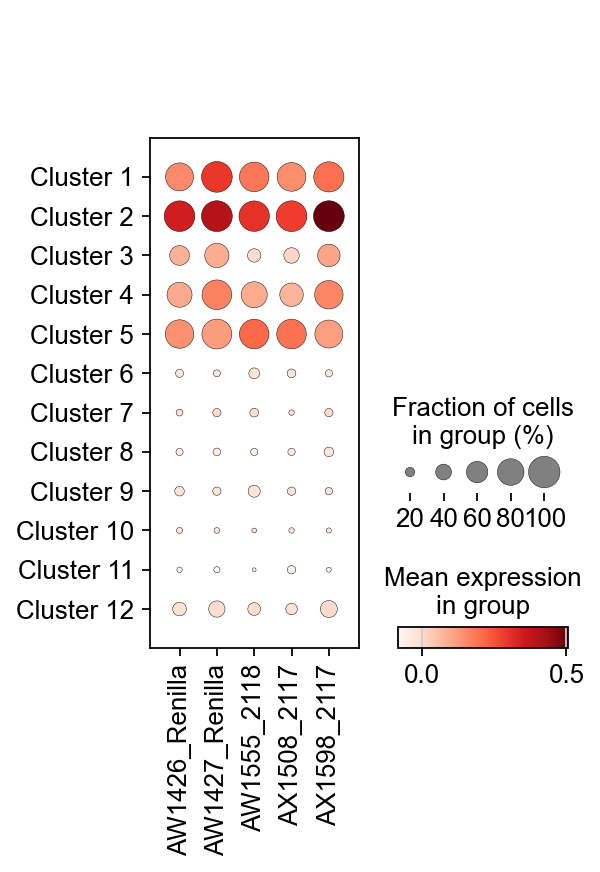

In [80]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [81]:
sc.tl.leiden(adata, resolution=0.3)
#sc.tl.leiden(adata, resolution=0.25)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_3374137/3206119172.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


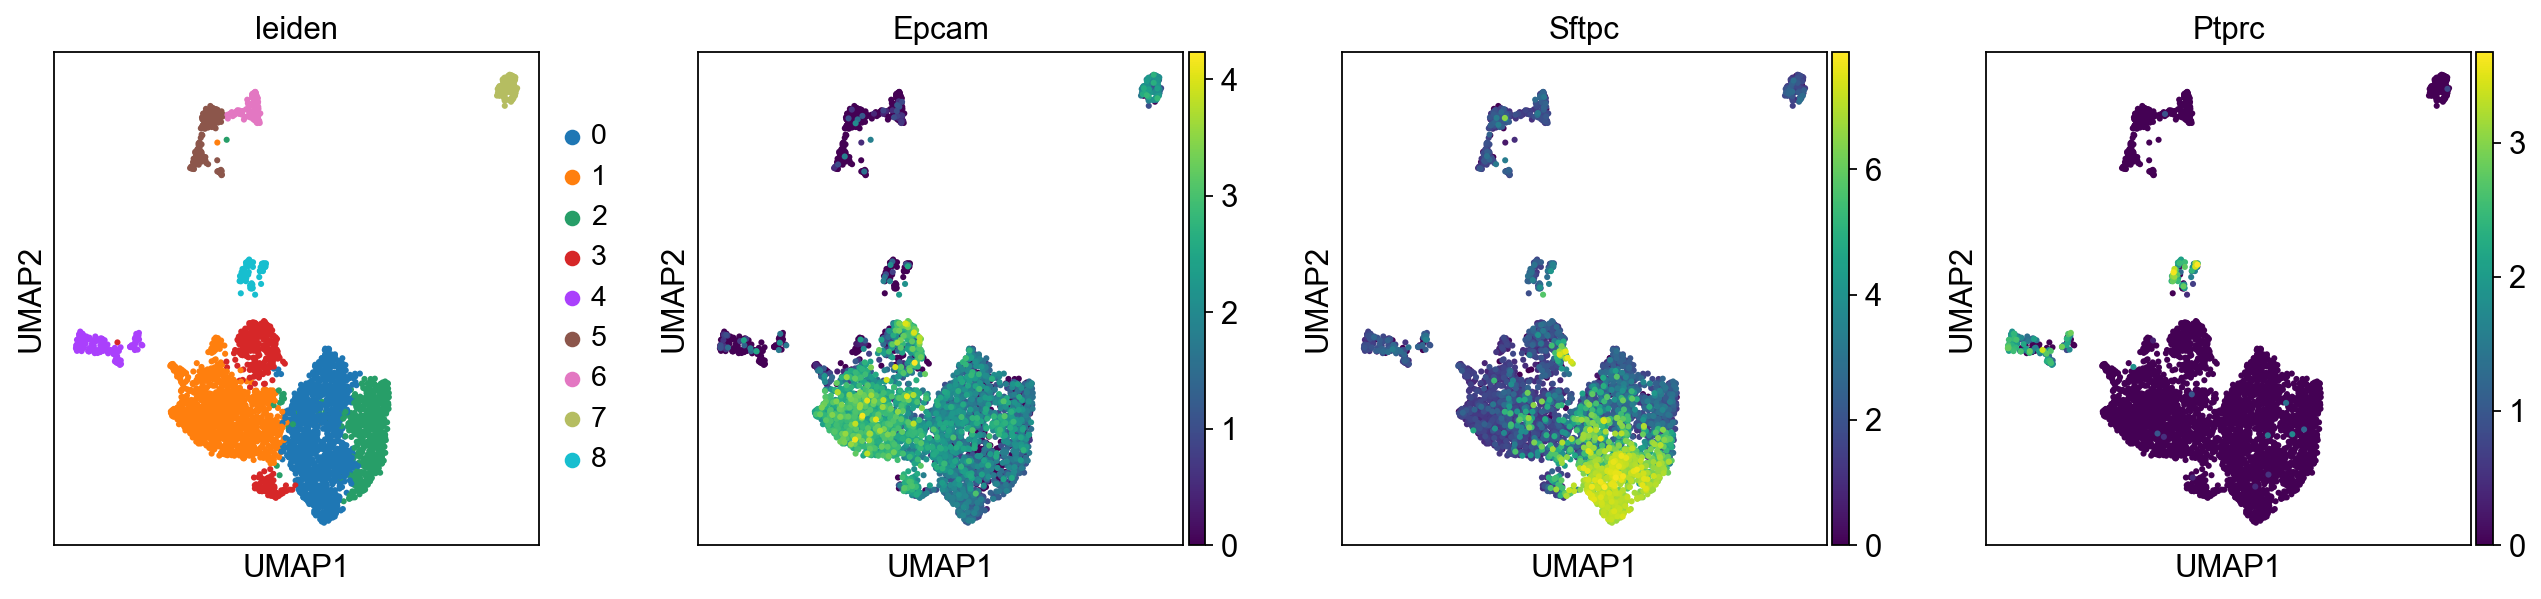

(None,)

In [82]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

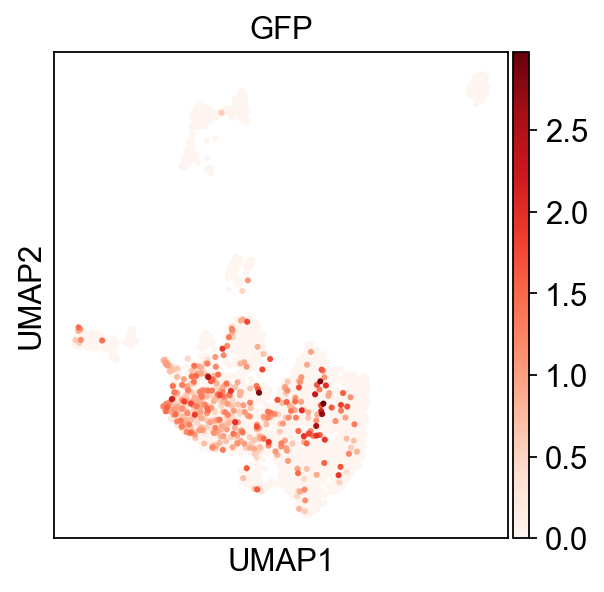

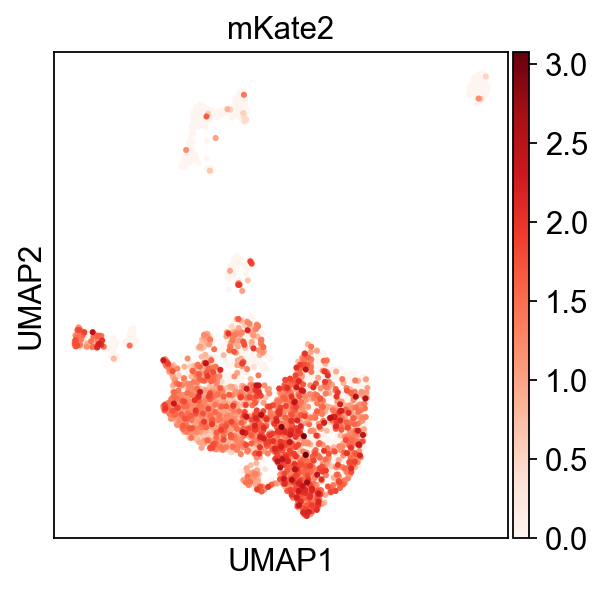

In [83]:
sc.pl.umap(adata, color=['GFP'], cmap='Reds')
sc.pl.umap(adata, color=['mKate2'], cmap='Reds')

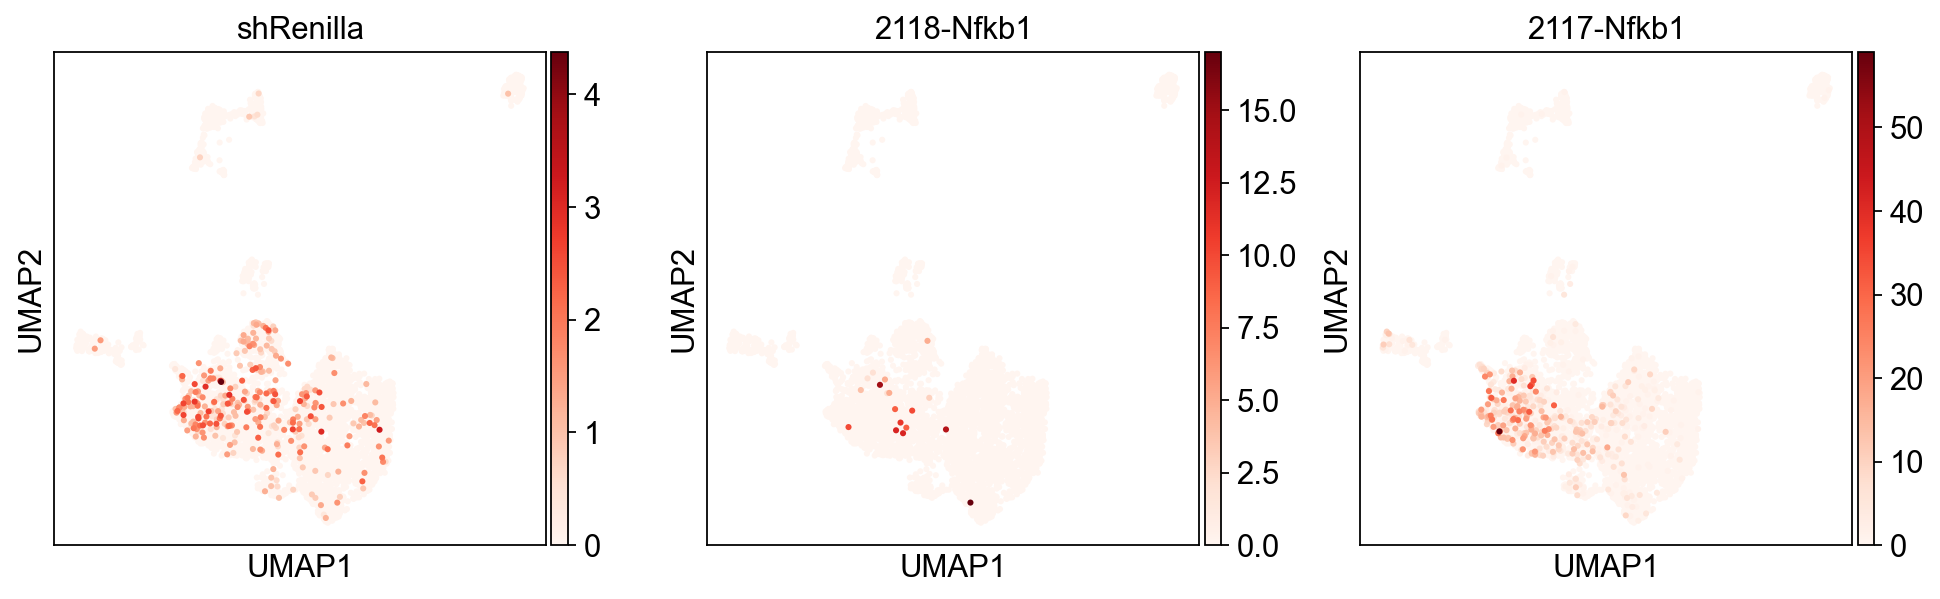

In [84]:
sc.pl.umap(adata, color=["shRenilla", "2118-Nfkb1", "2117-Nfkb1"], cmap='Reds')

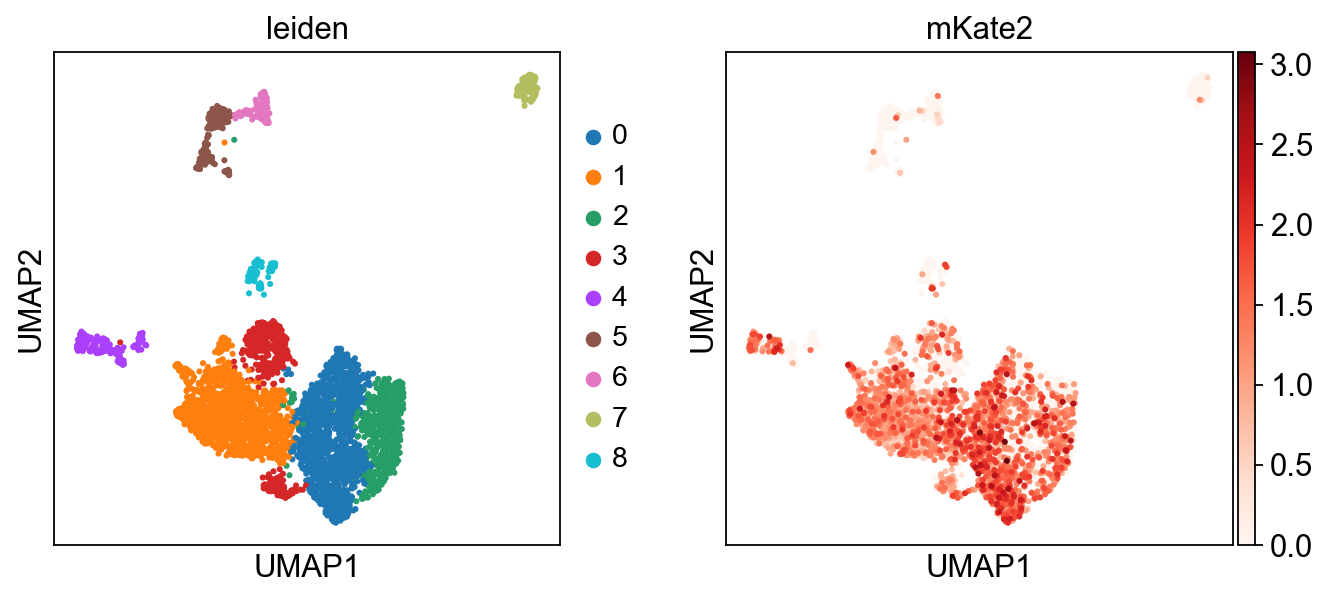

In [85]:
sc.pl.umap(adata, color=['leiden','mKate2'],cmap="Reds")

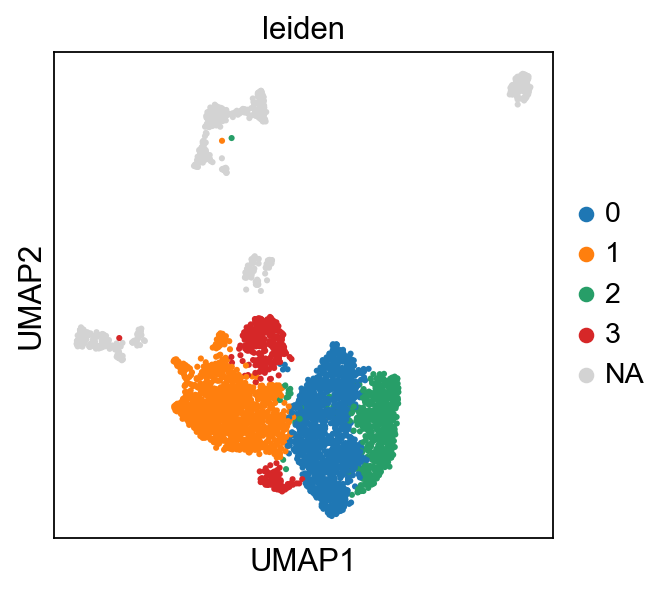

In [86]:
sc.pl.umap(adata, color=['leiden'], groups=['0','1','2','3'])

## Select Tumor Cells

In [87]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/JC2434-allmice.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','1','2','3']),:] # keep tumor cells
del adata2

In [88]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/tmp/ipykernel_3374137/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [89]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [90]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_3374137/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_3374137/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

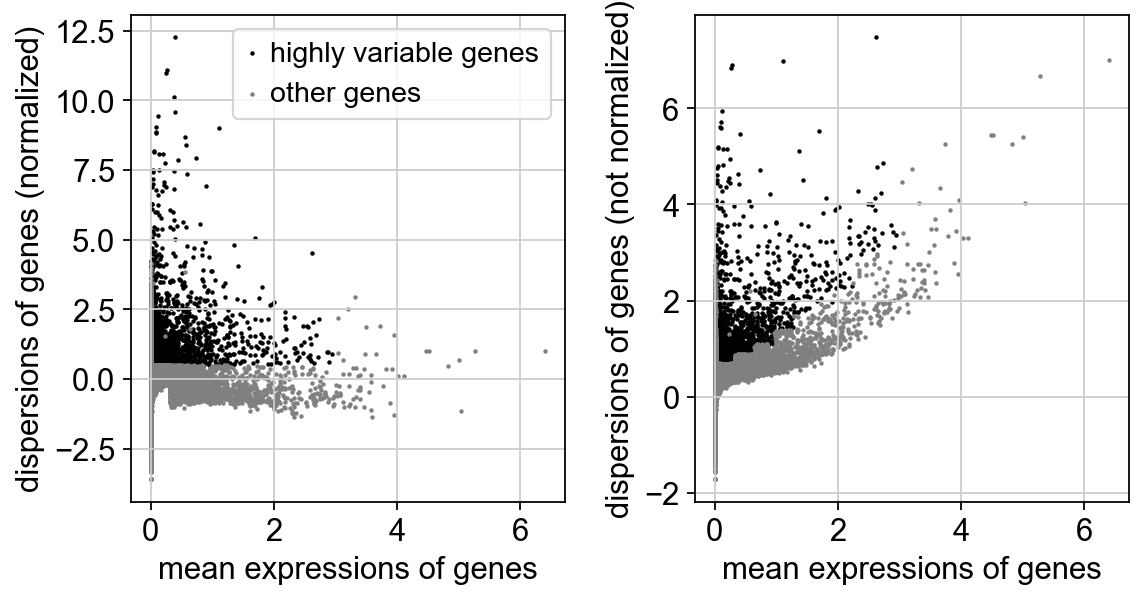

In [91]:
sc.pl.highly_variable_genes(adata)

In [92]:
adata.raw = adata

In [93]:
adata.write('write/JC2434-allmice-tumor.h5ad', compression='gzip')
#adata = sc.read('write/JC2434-allmice-tumor.h5ad')